<a href="https://colab.research.google.com/github/FlashyTwilight/Challenge-Alura-Latam-Part-two/blob/main/AMFR_CHALLENGE_PART_TWO_TELECOM_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análisis de Churn en Telecomunicaciones
Este cuaderno presenta un análisis exhaustivo del fenómeno de Churn (abandono de clientes) en el sector de telecomunicaciones.
El trabajo sigue un flujo completo de Ciencia de Datos, que abarca:

Carga y exploración de datos: Importación, comprensión de la estructura y análisis inicial.

Preparación y limpieza: Tratamiento de valores faltantes, codificación de variables y normalización.

Análisis exploratorio: Identificación de patrones, correlaciones y factores relevantes que influyen en la cancelación de clientes.

Modelado predictivo: Implementación y comparación de algoritmos de Machine Learning para predecir la probabilidad de abandono.

Evaluación de modelos: Uso de métricas clave como precisión, recall, F1-score y AUC-ROC para medir el desempeño.

Interpretación y conclusiones: Insights accionables para reducir la pérdida de clientes y mejorar la retención.

El objetivo final es proporcionar una visión clara y basada en datos que permita a la compañía anticipar el abandono de clientes y diseñar estrategias *efectivas* para fidelizarlos.

#0-Configuración Inicial y Carga de Datos
En esta sección, configuramos nuestro entorno de trabajo e importamos las librerías necesarias. Luego, cargamos los datos brutos desde una fuente pública.

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests # Para cargar datos desde URL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

print("Configuración inicial y librerías cargadas.")

# URL del dataset original
url_data = "https://raw.githubusercontent.com/FlashyTwilight/Challenge-Alura-Latam-Part-two/refs/heads/main/DATA.JSON"

print("\n--- Paso 0.1: Carga de Datos desde URL ---")
try:
    # Intenta obtener la respuesta de la URL
    respuesta = requests.get(url_data)
    respuesta.raise_for_status() # Lanza un error si la solicitud HTTP no fue exitosa

    # Carga los datos JSON directamente en un DataFrame de pandas
    df_clientes = pd.read_json(url_data)

    print("¡Datos cargados exitosamente en un DataFrame!")
    print("\nPrimeras 5 filas del DataFrame (df_clientes):")
    print(df_clientes.head())

    print("\nInformación general del DataFrame (df_clientes.info()):")
    df_clientes.info()

except requests.exceptions.RequestException as e:
    print(f"¡Error de conexión! No se pudo acceder a la URL. Por favor, verifica tu conexión a internet o la URL: {e}")
except Exception as e:
    print(f"¡Error al procesar los datos! Asegúrate de que el archivo JSON es válido y accesible: {e}")

print("\n--- Paso 0.2: Verificación de Duplicados por customerID ---")
num_duplicados_id = df_clientes['customerID'].duplicated().sum()

if num_duplicados_id > 0:
    print(f"¡Se encontraron {num_duplicados_id} clientes duplicados basándose en 'customerID'!")
    print("Eliminando registros duplicados...")
    df_clientes.drop_duplicates(subset=['customerID'], inplace=True)
    print(f"Duplicados eliminados. Ahora el número de filas es: {df_clientes.shape[0]}")
else:
    print("¡No se encontraron clientes duplicados por 'customerID'!")

Configuración inicial y librerías cargadas.

--- Paso 0.1: Carga de Datos desde URL ---
¡Datos cargados exitosamente en un DataFrame!

Primeras 5 filas del DataFrame (df_clientes):
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            inter

#1. Limpieza y Tratamiento de Datos (Aplanamiento y Tipos de Datos)
Esta etapa se enfoca en asegurar la calidad y coherencia de los datos. Esto incluye el manejo de estructuras anidadas (diccionarios dentro de columnas), la corrección de tipos de datos y el tratamiento de valores ausentes.

In [ ]:
print("--- Paso 1: Aplanando columnas con diccionarios y corrigiendo 'TotalCharges' ---")

# Identificando y aplanando columnas que contienen diccionarios
columnas_a_aplanar = []
for col in df_clientes.columns:
    if len(df_clientes) > 0 and pd.notna(df_clientes[col].iloc[0]) and isinstance(df_clientes[col].iloc[0], dict):
        columnas_a_aplanar.append(col)

if columnas_a_aplanar:
    print(f"Columnas identificadas con diccionarios que necesitan ser aplanadas: {columnas_a_aplanar}")
    for col_dict in columnas_a_aplanar:
        print(f"Aplanando la columna '{col_dict}'...")
        # Normalizar el JSON y prefijar las nuevas columnas para evitar conflictos
        df_temp = pd.json_normalize(df_clientes[col_dict])
        df_temp.columns = [f"{col_dict}_{sub_col}" for sub_col in df_temp.columns]
        df_clientes = pd.concat([df_clientes.drop(columns=[col_dict]), df_temp], axis=1)
    print("¡Columnas aplanadas con éxito!")
else:
    print("No se encontraron columnas de diccionario para aplanar.")

print("\nNombres de todas las columnas DESPUÉS del aplanamiento:")
print(df_clientes.columns.tolist())

# --- Tratamiento específico de 'TotalCharges' ---
# Identificamos el nombre real de la columna TotalCharges después del aplanamiento
nombre_columna_cargos_totales = 'account_Charges.Total' # Nombre esperado tras el aplanamiento de 'account'

if nombre_columna_cargos_totales in df_clientes.columns:
    print(f"\n--- Intentando convertir '{nombre_columna_cargos_totales}' a numérico y manejando vacíos/nulos: ---")
    # Convertir a numérico, forzando errores a NaN
    df_clientes[nombre_columna_cargos_totales] = pd.to_numeric(df_clientes[nombre_columna_cargos_totales], errors='coerce')

    # Contar y rellenar los valores nulos que resultaron de la conversión
    null_count_tc = df_clientes[nombre_columna_cargos_totales].isnull().sum()
    if null_count_tc > 0:
        print(f"Se encontraron {null_count_tc} valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
        print(f"Rellenando los valores nulos con 0 para '{nombre_columna_cargos_totales}'.")
        df_clientes[nombre_columna_cargos_totales].fillna(0, inplace=True)
    else:
        print(f"No se encontraron valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
else:
    print(f"\n¡La columna '{nombre_columna_cargos_totales}' NO se encontró en el DataFrame después del aplanamiento!")
    print("Por favor, revisa los nombres de las columnas para encontrar el correcto.")

print("\nTipos de datos después del aplanamiento y limpieza de 'TotalCharges':")
df_clientes.info()

--- Paso 1: Aplanando columnas con diccionarios y corrigiendo 'TotalCharges' ---
Columnas identificadas con diccionarios que necesitan ser aplanadas: ['customer', 'phone', 'internet', 'account']
Aplanando la columna 'customer'...
Aplanando la columna 'phone'...
Aplanando la columna 'internet'...
Aplanando la columna 'account'...
¡Columnas aplanadas con éxito!

Nombres de todas las columnas DESPUÉS del aplanamiento:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges.Monthly', 'account_Charges.Total']

--- Intentando convertir 'account_Charges.Total' a numérico y manejando vacíos/nulos: ---
Se e

/tmp/ipython-input-3057487575.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clientes[nombre_columna_cargos_totales].fillna(0, inplace=True)


#2. Generación de Características y Estandarización de Variables
Aquí creamos nuevas variables que pueden ser útiles para el análisis y los modelos, y transformamos las variables categóricas binarias (como 'Sí'/'No') a formato numérico (0 y 1). También renombramos columnas para mayor claridad.

In [ ]:
# ... (Código previo del Paso 0 y Paso 1 sin cambios) ...

print("--- Paso 2: Creación de 'Cuentas_Diarias' y Estandarización de Variables ---")

# 1. Creación de la columna 'Cuentas_Diarias'
columna_facturacion_mensual = 'account_Charges.Monthly'
if columna_facturacion_mensual in df_clientes.columns:
    dias_en_mes = 30
    df_clientes['Cuentas_Diarias'] = pd.to_numeric(df_clientes[columna_facturacion_mensual], errors='coerce') / dias_en_mes
    df_clientes['Cuentas_Diarias'].fillna(0, inplace=True) # Rellenar nulos si los hubiera

    print(f"Columna 'Cuentas_Diarias' creada y calculada a partir de '{columna_facturacion_mensual}'.")
    print("Primeras 5 filas con la nueva columna:")
    print(df_clientes[['customerID', columna_facturacion_mensual, 'Cuentas_Diarias']].head())
else:
    print(f"Error: La columna '{columna_facturacion_mensual}' no se encontró. No se pudo crear 'Cuentas_Diarias'.")

# 2. Convertir valores binarios (Sí/No, Male/Female, etc.) a 1 y 0
print("\n--- Convirtiendo valores binarios a numéricos (1 y 0): ---")
mapeos_binarios = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0,
    'No phone service': 0,
    'No internet service': 0
}

# Columnas binarias a transformar (revisar nombres exactos después del aplanamiento)
columnas_binarias_a_transformar = [
    'Churn',
    'customer_Partner',
    'customer_Dependents',
    'phone_PhoneService',
    'phone_MultipleLines',
    'internet_OnlineSecurity',
    'internet_OnlineBackup',
    'internet_DeviceProtection',
    'internet_TechSupport',
    'internet_StreamingTV',
    'internet_StreamingMovies',
    'account_PaperlessBilling',
    'customer_gender' # Incluir el género aquí
]

for col in columnas_binarias_a_transformar:
    if col in df_clientes.columns and df_clientes[col].dtype == 'object': # Solo procesar si es de tipo objeto
        print(f"Procesando columna binaria '{col}' (Valores únicos antes: {df_clientes[col].unique()})...")
        df_clientes[col] = df_clientes[col].replace(mapeos_binarios)
        print(f"Valores únicos después: {df_clientes[col].unique()}")
    elif col in df_clientes.columns:
        print(f"Columna '{col}' ya es numérica o no es un objeto, saltando conversión binaria.")
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para conversión binaria.")

# --- INICIO DE LA CORRECCIÓN PARA CHURN ---
# Después de intentar mapear 'Churn', verifica y maneja los valores restantes no numéricos
if 'Churn' in df_clientes.columns and (df_clientes['Churn'] == '').any():
    print("\nDetectados valores vacíos (cadenas vacías) en la columna 'Churn'.")
    # Convertir cadenas vacías a NaN y luego eliminar las filas con NaN
    original_rows = df_clientes.shape[0]
    df_clientes['Churn'] = df_clientes['Churn'].replace('', np.nan)
    df_clientes.dropna(subset=['Churn'], inplace=True)
    df_clientes['Churn'] = df_clientes['Churn'].astype(int) # Asegurarse de que sea int
    print(f"Se eliminaron {original_rows - df_clientes.shape[0]} filas con 'Churn' vacío. Nueva cantidad de filas: {df_clientes.shape[0]}.")
    print(f"Valores únicos de 'Churn' después de limpieza: {df_clientes['Churn'].unique()}")
# --- FIN DE LA CORRECCIÓN PARA CHURN ---


# 3. Renombrar columnas para mayor claridad
print("\n--- Renombrando columnas para mayor claridad: ---")
nuevos_nombres_columnas = {
    'customerID': 'ID_Cliente',
    'customer_gender': 'Genero_Cliente',
    'customer_SeniorCitizen': 'Cliente_TerceraEdad',
    'customer_Partner': 'Cliente_Pareja',
    'customer_Dependents': 'Cliente_Dependientes',
    'customer_tenure': 'Antiguedad_Meses',
    'phone_PhoneService': 'Servicio_Telefono',
    'phone_MultipleLines': 'Multiples_Lineas',
    'internet_InternetService': 'Servicio_Internet',
    'internet_OnlineSecurity': 'Seguridad_Online',
    'internet_OnlineBackup': 'Respaldo_Online',
    'internet_DeviceProtection': 'Proteccion_Dispositivo',
    'internet_TechSupport': 'Soporte_Tecnico',
    'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Peliculas',
    'account_Contract': 'Tipo_Contrato',
    'account_PaperlessBilling': 'Facturacion_Electronica',
    'account_PaymentMethod': 'Metodo_Pago',
    'account_Charges.Monthly': 'Cargos_Mensuales',
    'account_Charges.Total': 'Cargos_Totales',
}

# Aplicar el renombramiento. Usamos .copy() para evitar SettingWithCopyWarning
df_clientes = df_clientes.rename(columns=nuevos_nombres_columnas).copy()

print("Columnas renombradas. Nuevos nombres (primeras 20):")
print(df_clientes.columns.tolist()[:20]) # Mostrar solo las primeras para no abrumar

print("\nTipos de datos después de la estandarización y transformación:")
df_clientes.info()
print("\nPrimeras 5 filas del DataFrame transformado:")
print(df_clientes.head())

--- Paso 2: Creación de 'Cuentas_Diarias' y Estandarización de Variables ---
Columna 'Cuentas_Diarias' creada y calculada a partir de 'account_Charges.Monthly'.
Primeras 5 filas con la nueva columna:
   customerID  account_Charges.Monthly  Cuentas_Diarias
0  0002-ORFBO                     65.6         2.186667
1  0003-MKNFE                     59.9         1.996667
2  0004-TLHLJ                     73.9         2.463333
3  0011-IGKFF                     98.0         3.266667
4  0013-EXCHZ                     83.9         2.796667

--- Convirtiendo valores binarios a numéricos (1 y 0): ---
Procesando columna binaria 'Churn' (Valores únicos antes: ['No' 'Yes' ''])...
Valores únicos después: [0 1 '']
Procesando columna binaria 'customer_Partner' (Valores únicos antes: ['Yes' 'No'])...
Valores únicos después: [1 0]
Procesando columna binaria 'customer_Dependents' (Valores únicos antes: ['Yes' 'No'])...
Valores únicos después: [1 0]
Procesando columna binaria 'phone_PhoneService' (Valores ú

/tmp/ipython-input-4132016276.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clientes['Cuentas_Diarias'].fillna(0, inplace=True) # Rellenar nulos si los hubiera
/tmp/ipython-input-4132016276.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clientes[col] = df_clientes[col].replace(map

#3. Análisis Exploratorio de Datos (EDA) y Correlación
En esta sección, realizamos un análisis descriptivo de los datos y visualizamos las relaciones clave, incluyendo la distribución del Churn y las correlaciones entre variables.3. Análisis Exploratorio de Datos (EDA) y Correlación
En esta sección, realizamos un análisis descriptivo de los datos y visualizamos las relaciones clave, incluyendo la distribución del Churn y las correlaciones entre variables.

Configuración inicial y librerías cargadas.

--- Paso 0.1: Carga de Datos desde URL ---
¡Datos cargados exitosamente en un DataFrame!

Primeras 5 filas del DataFrame (df_clientes):
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            inter

/tmp/ipython-input-4089247450.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clientes[nombre_columna_cargos_totales].fillna(0, inplace=True)
/tmp/ipython-input-4089247450.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

Servicio_Internet
Fiber optic    3198
DSL            2488
No             1581
Name: count, dtype: int64
Valores únicos: ['DSL' 'Fiber optic' 'No']

--- Columna: 'Tipo_Contrato' ---
Tipo_Contrato
Month-to-month    4005
Two year          1743
One year          1519
Name: count, dtype: int64
Valores únicos: ['One year' 'Month-to-month' 'Two year']

--- Columna: 'Metodo_Pago' ---
Metodo_Pago
Electronic check             2445
Mailed check                 1665
Bank transfer (automatic)    1589
Credit card (automatic)      1568
Name: count, dtype: int64
Valores únicos: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']

--- Distribución de la Variable Objetivo 'Churn' ---

Recuento de Clientes por Estado de Churn:
Churn
0    5174
1    1869
      224
Name: count, dtype: int64

Porcentaje de Clientes por Estado de Churn:
Churn
0    71.20
1    25.72
      3.08
Name: proportion, dtype: float64


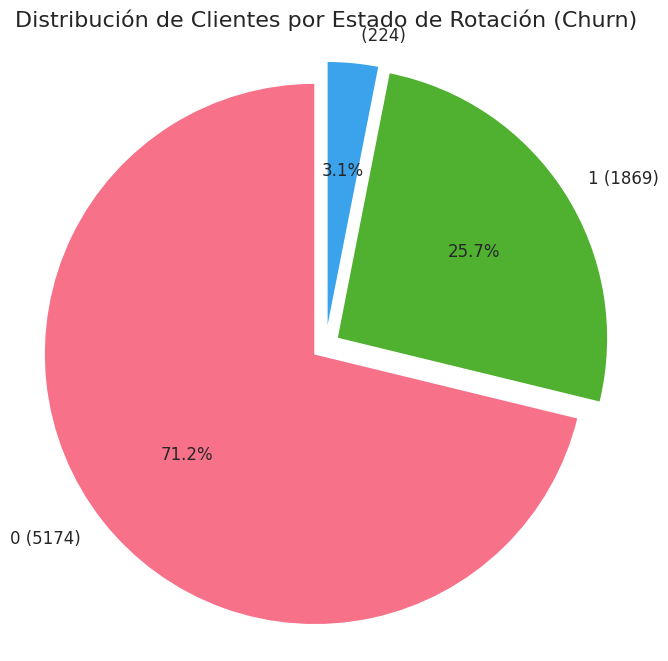

/tmp/ipython-input-4089247450.py:247: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df_clientes, palette=['#4CAF50', '#FF5733'] if len(churn_counts) == 2 else 'viridis')


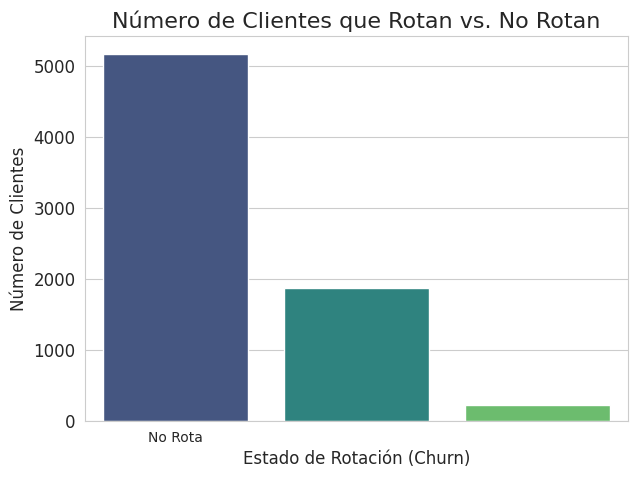


--- Matriz de Correlación entre Variables Numéricas ---


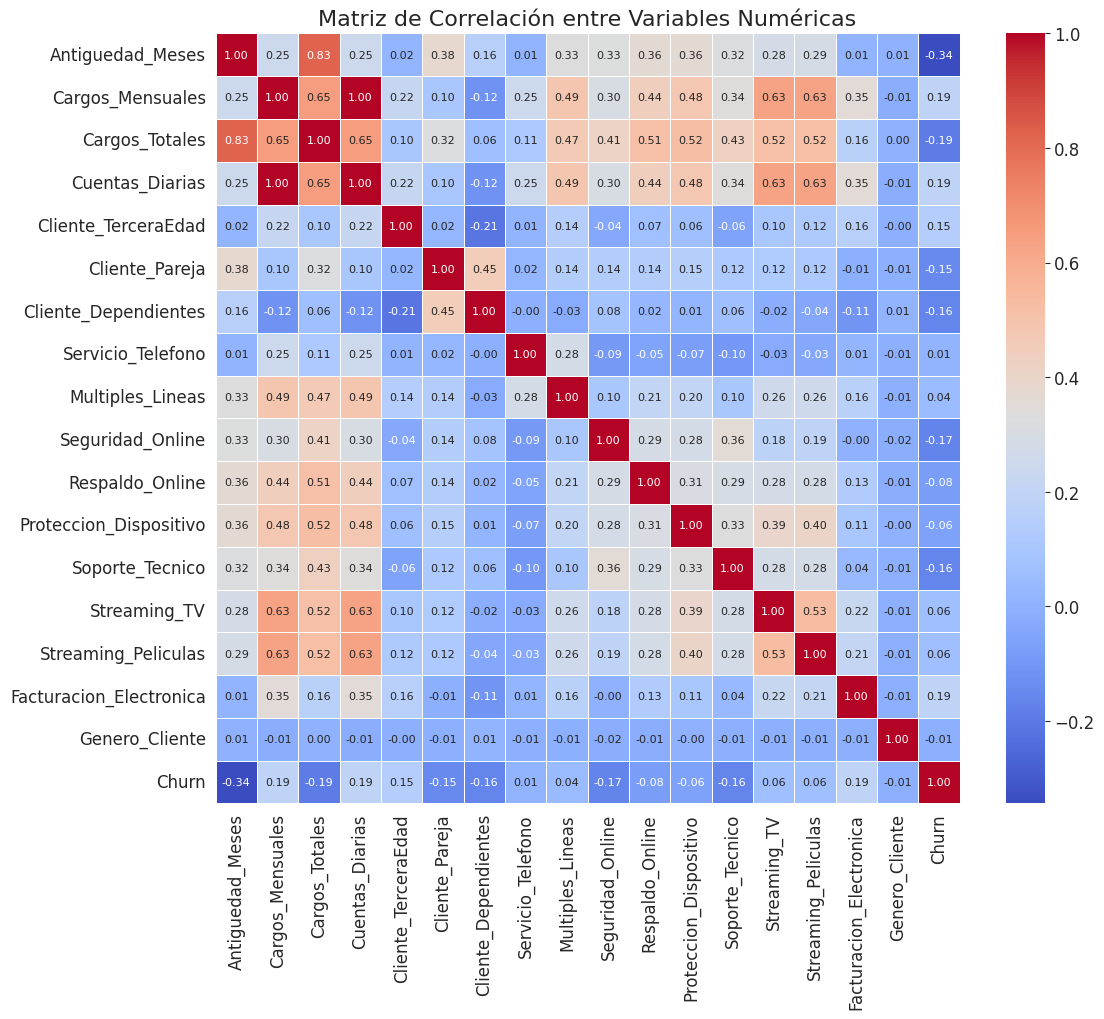


--- Análisis Dirigido: Churn por variables categóricas ---

Analizando 'Genero_Cliente' en relación con 'Churn'


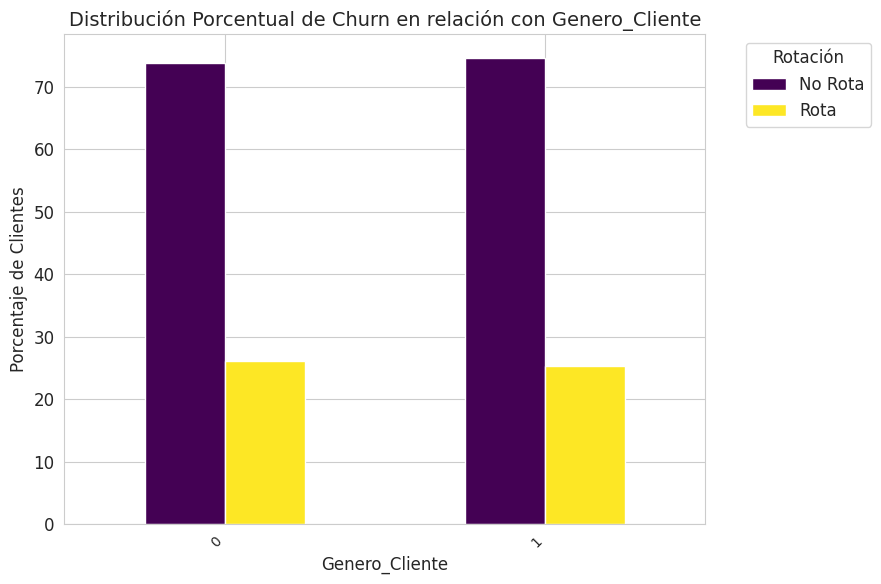


Analizando 'Cliente_TerceraEdad' en relación con 'Churn'


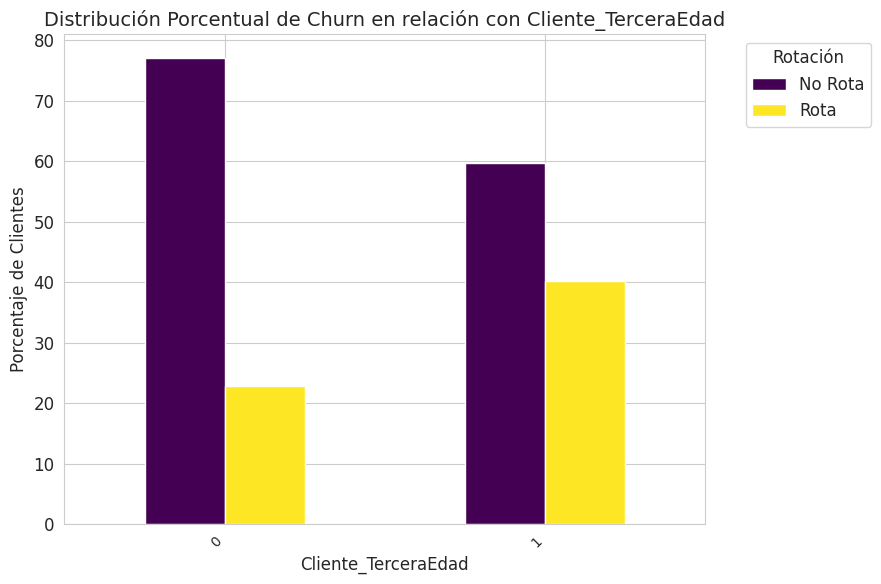


Analizando 'Cliente_Pareja' en relación con 'Churn'


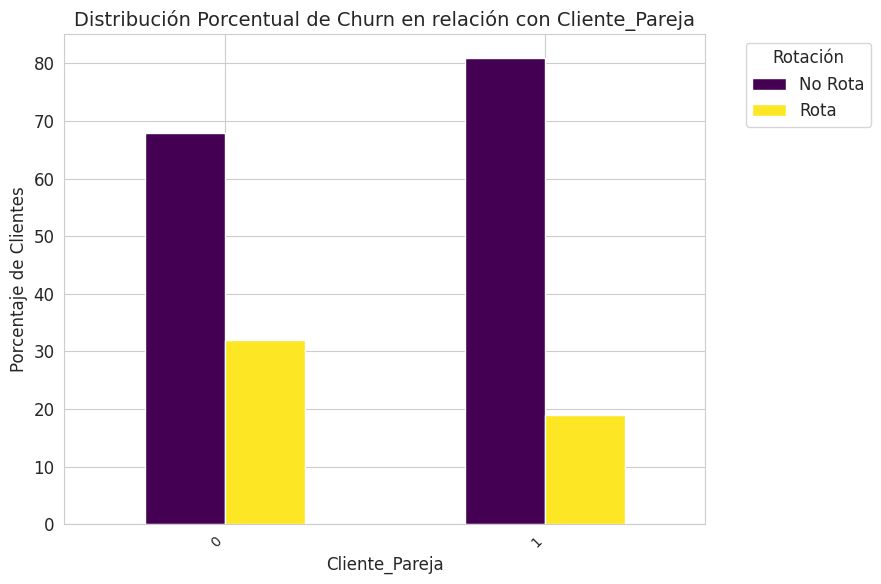


Analizando 'Cliente_Dependientes' en relación con 'Churn'


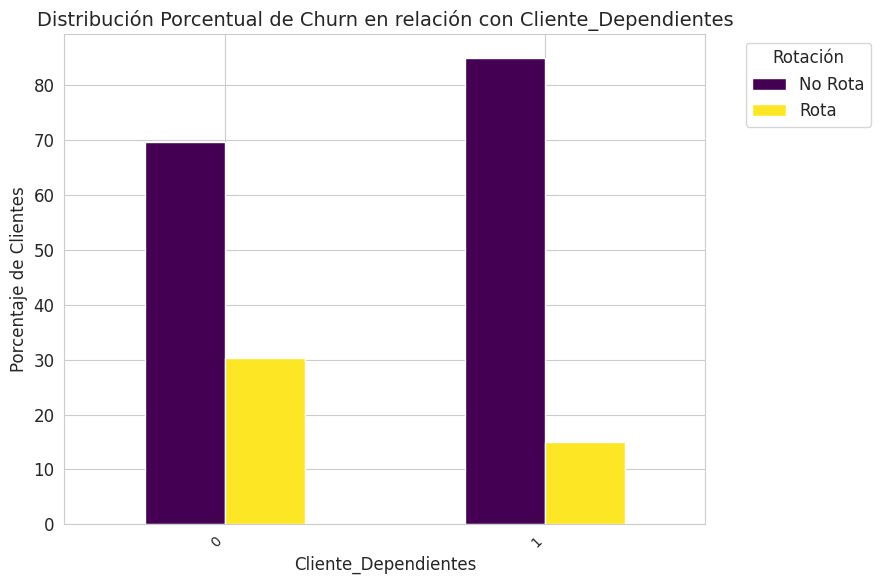


Analizando 'Servicio_Telefono' en relación con 'Churn'


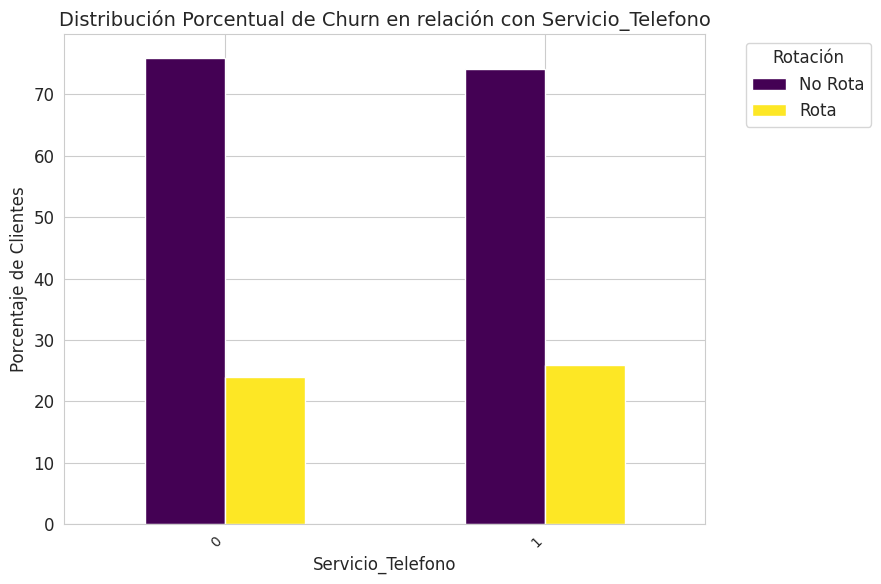


Analizando 'Multiples_Lineas' en relación con 'Churn'


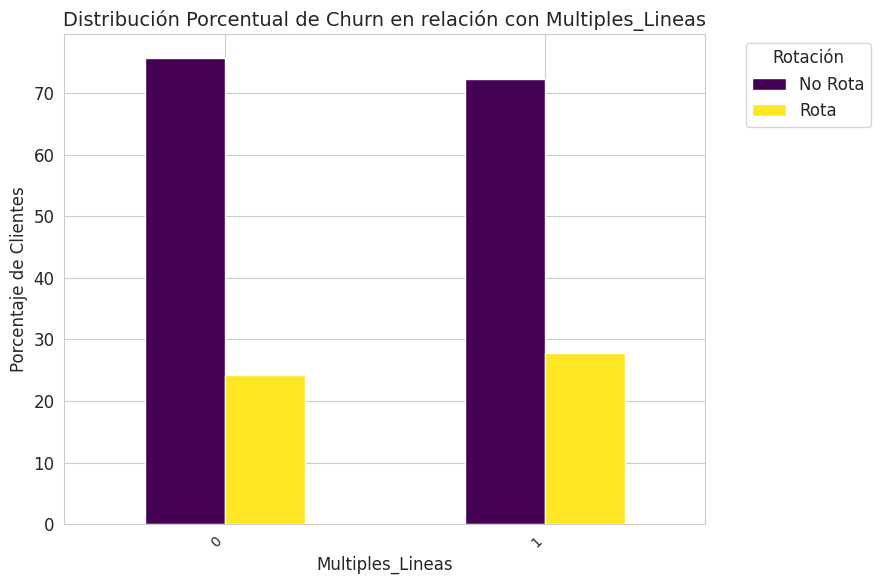


Analizando 'Servicio_Internet' en relación con 'Churn'


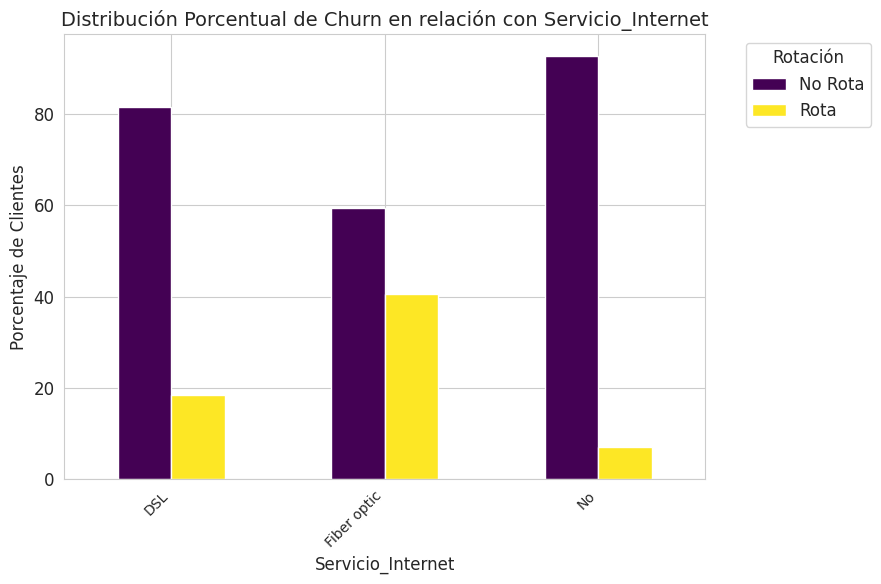


Analizando 'Seguridad_Online' en relación con 'Churn'


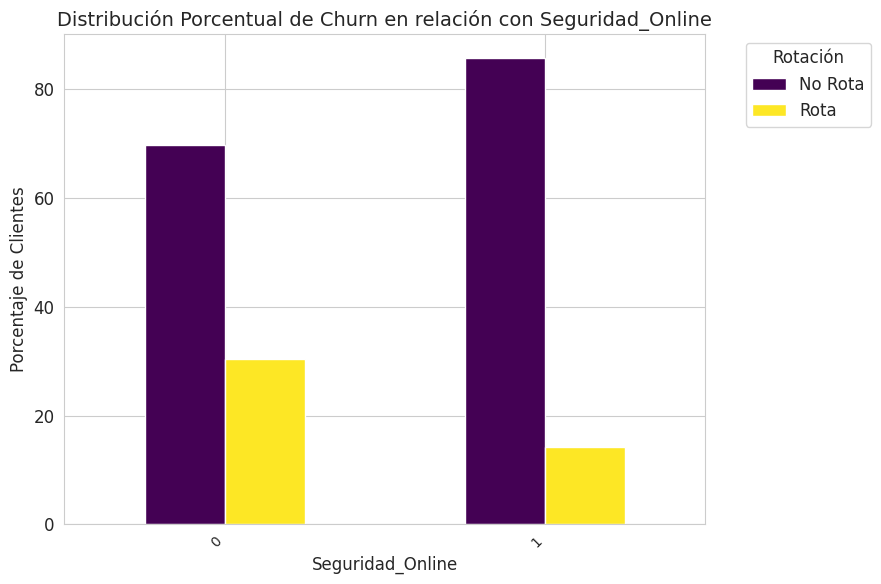


Analizando 'Respaldo_Online' en relación con 'Churn'


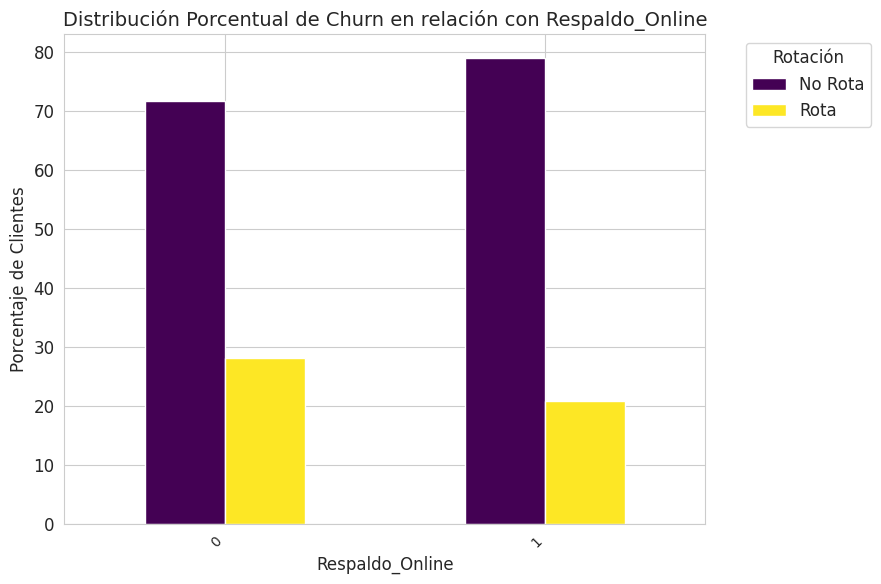


Analizando 'Proteccion_Dispositivo' en relación con 'Churn'


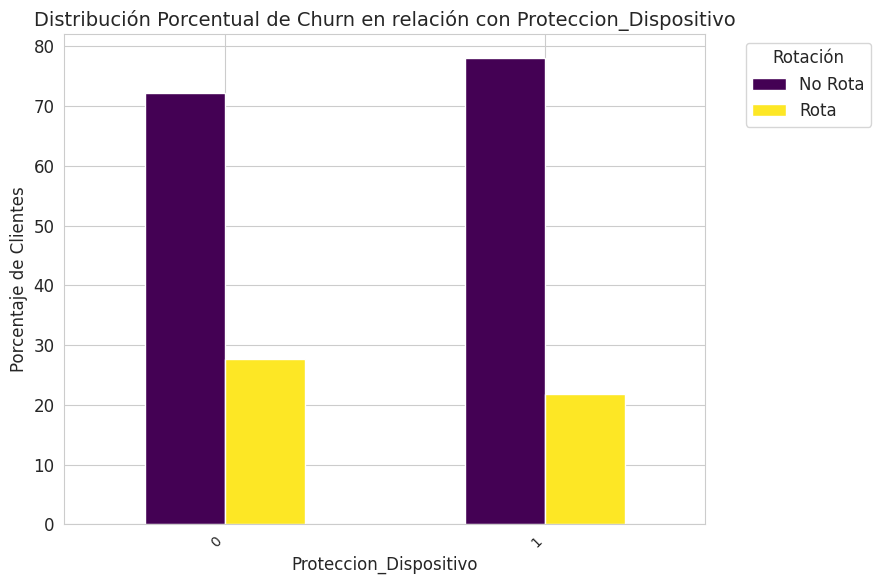


Analizando 'Soporte_Tecnico' en relación con 'Churn'


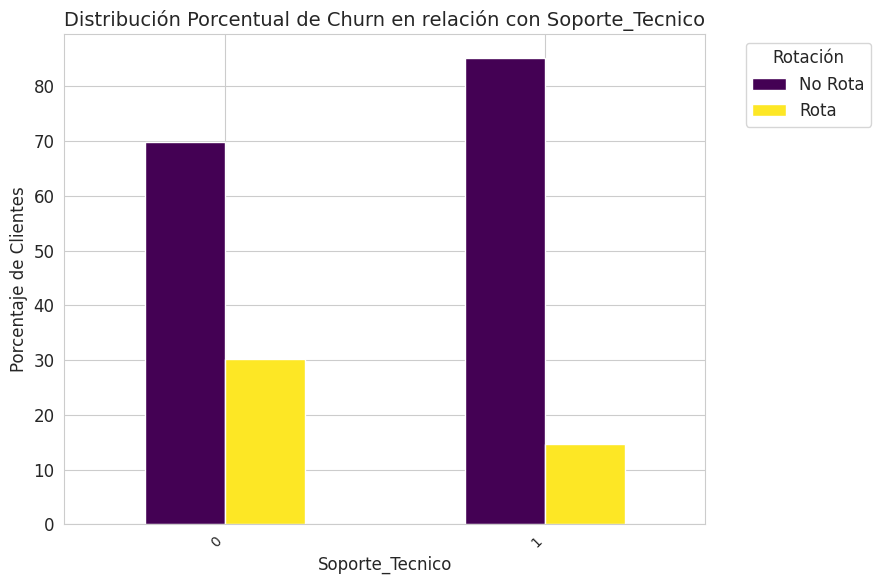


Analizando 'Streaming_TV' en relación con 'Churn'


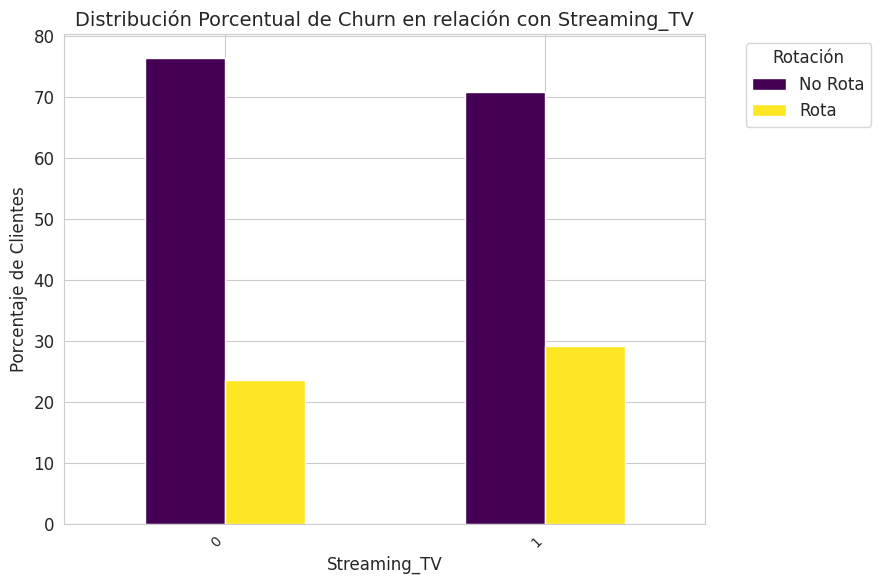


Analizando 'Streaming_Peliculas' en relación con 'Churn'


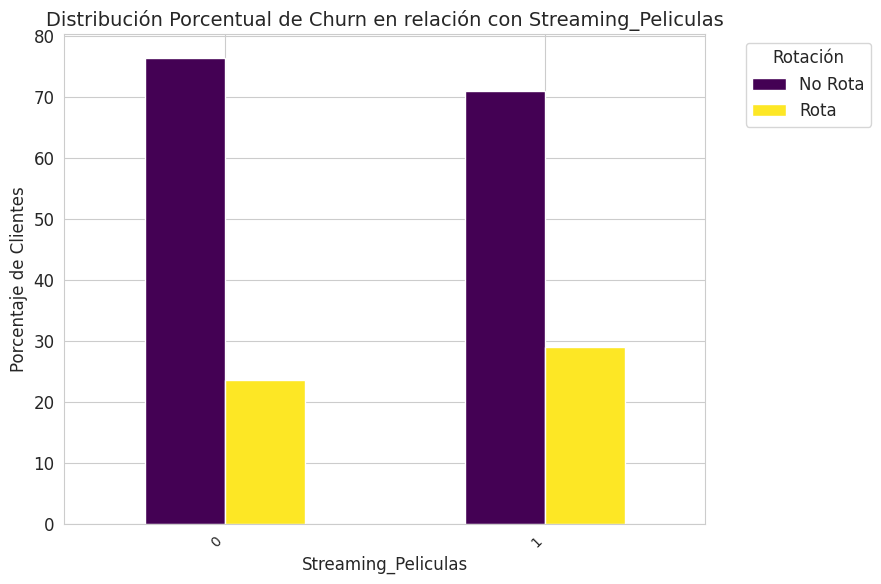


Analizando 'Tipo_Contrato' en relación con 'Churn'


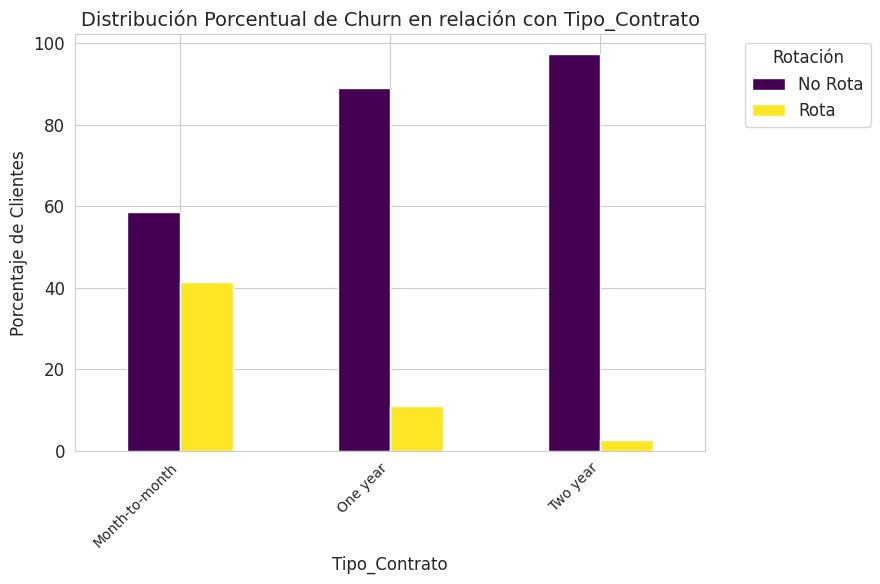


Analizando 'Facturacion_Electronica' en relación con 'Churn'


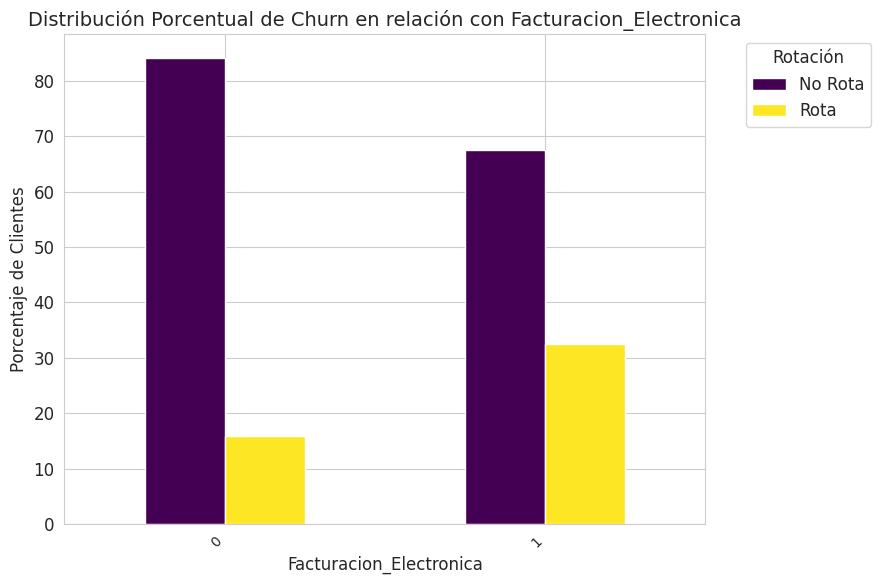


Analizando 'Metodo_Pago' en relación con 'Churn'


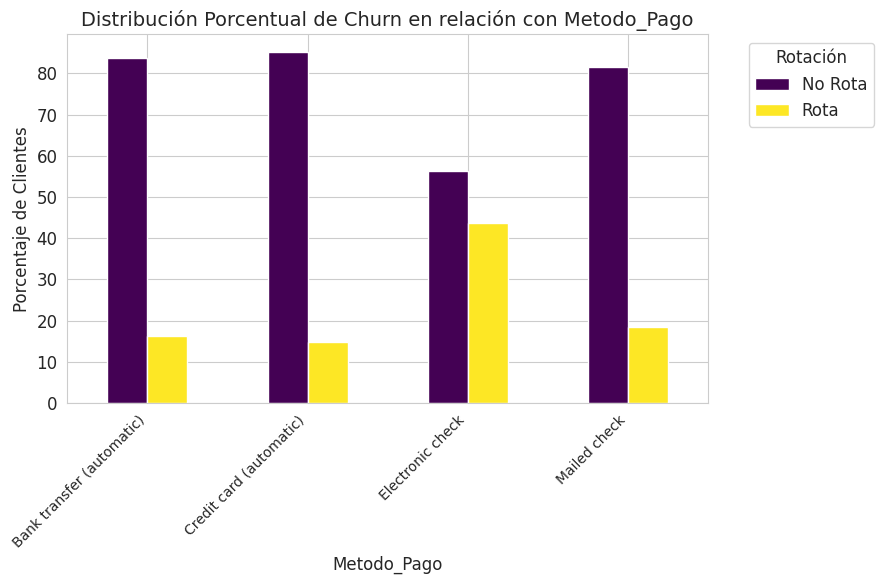


--- Análisis Dirigido: Churn por variables numéricas ---

Analizando 'Antiguedad_Meses' en relación con 'Churn'


/tmp/ipython-input-4089247450.py:322: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df_clientes, palette='magma')


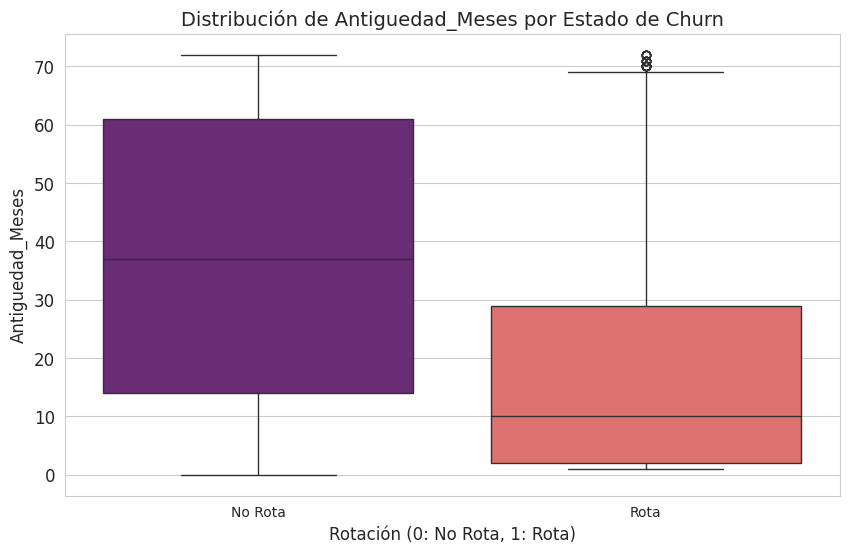

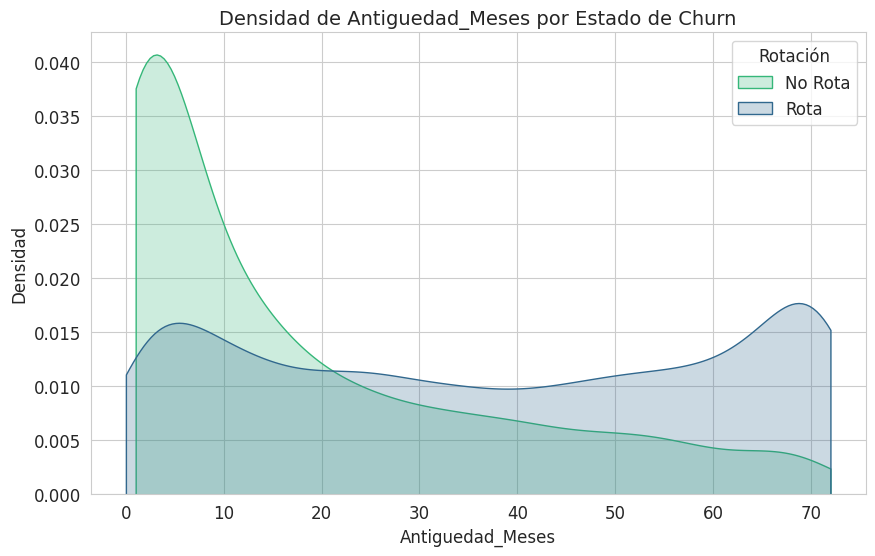


Analizando 'Cargos_Mensuales' en relación con 'Churn'


/tmp/ipython-input-4089247450.py:322: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df_clientes, palette='magma')


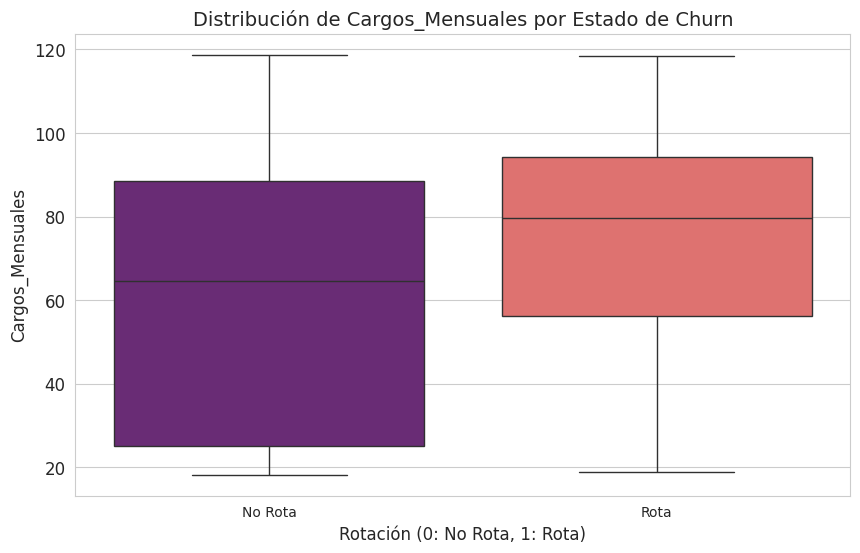

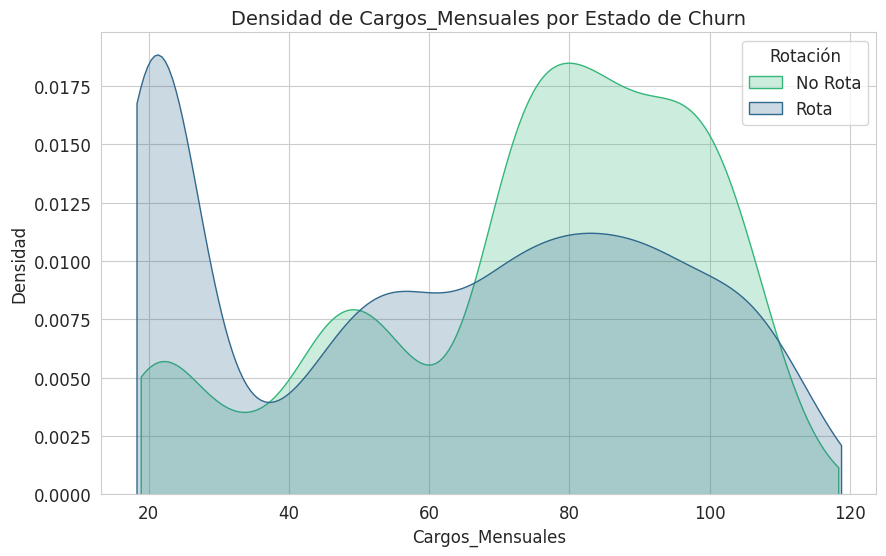


Analizando 'Cargos_Totales' en relación con 'Churn'


/tmp/ipython-input-4089247450.py:322: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df_clientes, palette='magma')


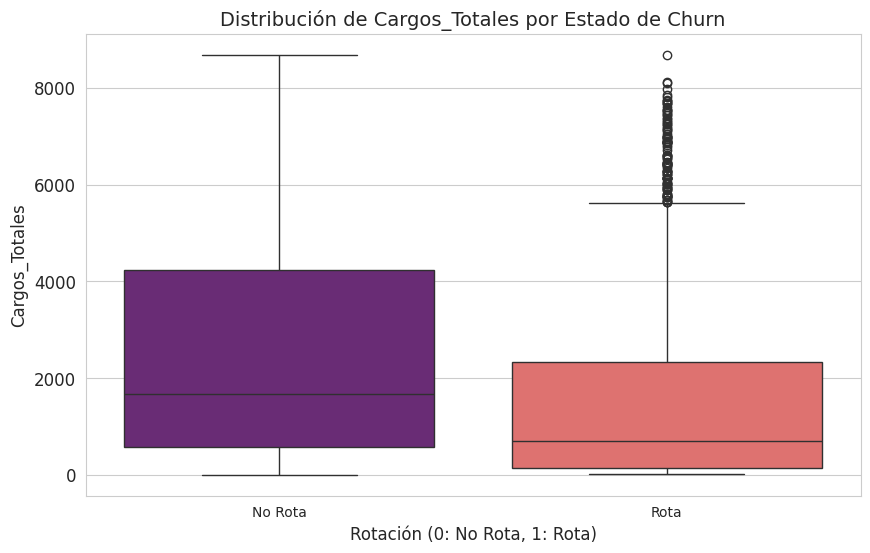

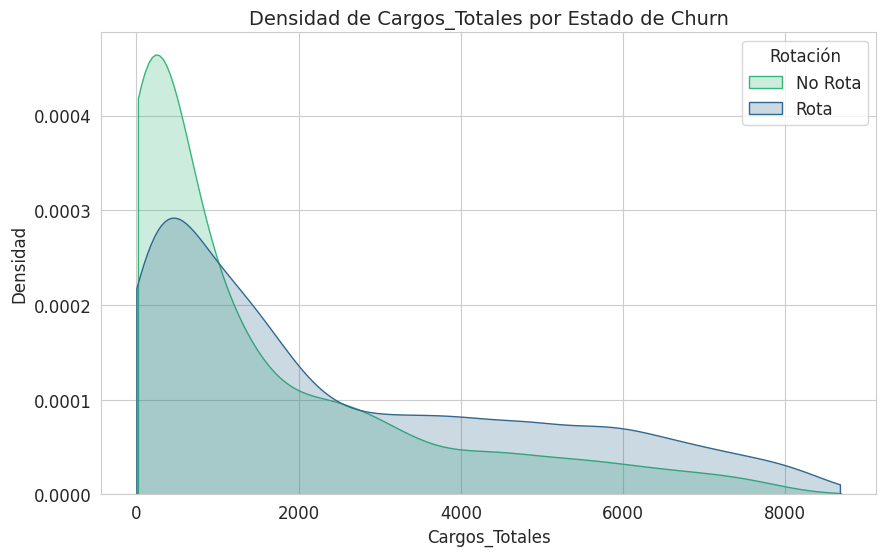


Analizando 'Cuentas_Diarias' en relación con 'Churn'


/tmp/ipython-input-4089247450.py:322: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df_clientes, palette='magma')


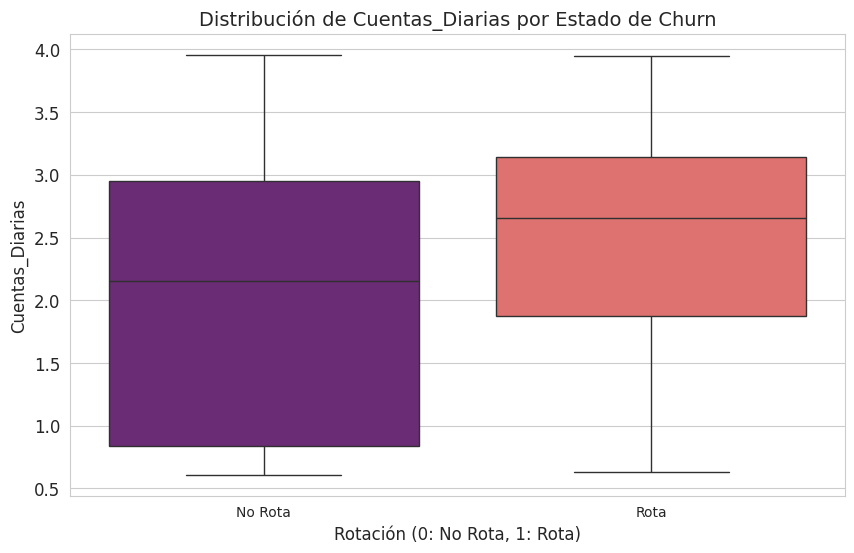

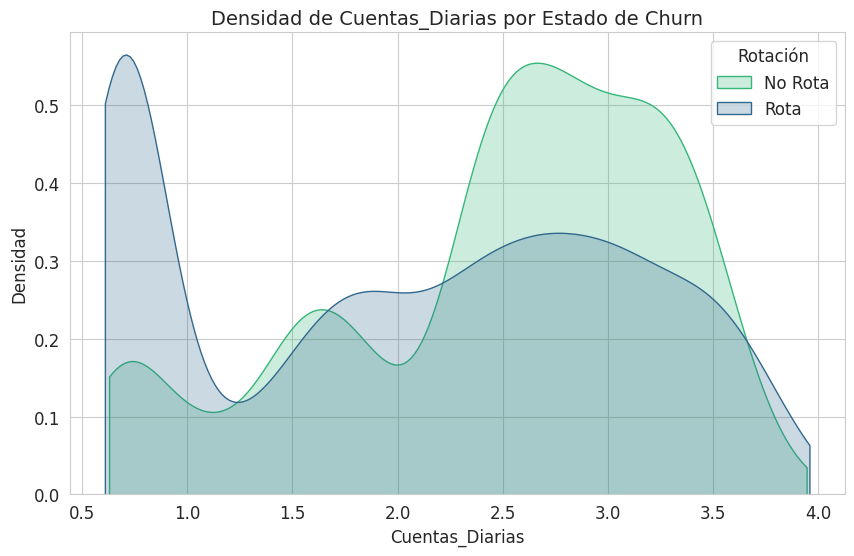


Análisis Exploratorio de Datos (EDA) completado.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests # Para cargar datos desde URL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

print("Configuración inicial y librerías cargadas.")

# URL del dataset original
url_data = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

print("\n--- Paso 0.1: Carga de Datos desde URL ---")
try:
    # Intenta obtener la respuesta de la URL
    respuesta = requests.get(url_data)
    respuesta.raise_for_status() # Lanza un error si la solicitud HTTP no fue exitosa

    # Carga los datos JSON directamente en un DataFrame de pandas
    df_clientes = pd.read_json(url_data)

    print("¡Datos cargados exitosamente en un DataFrame!")
    print("\nPrimeras 5 filas del DataFrame (df_clientes):")
    print(df_clientes.head())

    print("\nInformación general del DataFrame (df_clientes.info()):")
    df_clientes.info()

except requests.exceptions.RequestException as e:
    print(f"¡Error de conexión! No se pudo acceder a la URL. Por favor, verifica tu conexión a internet o la URL: {e}")
except Exception as e:
    print(f"¡Error al procesar los datos! Asegúrate de que el archivo JSON es válido y accesible: {e}")

print("\n--- Paso 0.2: Verificación de Duplicados por customerID ---")
num_duplicados_id = df_clientes['customerID'].duplicated().sum()

if num_duplicados_id > 0:
    print(f"¡Se encontraron {num_duplicados_id} clientes duplicados basándose en 'customerID'!")
    print("Eliminando registros duplicados...")
    df_clientes.drop_duplicates(subset=['customerID'], inplace=True)
    print(f"Duplicados eliminados. Ahora el número de filas es: {df_clientes.shape[0]}")
else:
    print("¡No se encontraron clientes duplicados por 'customerID'!")


print("--- Paso 1: Aplanando columnas con diccionarios y corrigiendo 'TotalCharges' ---")

# Identificando y aplanando columnas que contienen diccionarios
columnas_a_aplanar = []
for col in df_clientes.columns:
    if len(df_clientes) > 0 and pd.notna(df_clientes[col].iloc[0]) and isinstance(df_clientes[col].iloc[0], dict):
        columnas_a_aplanar.append(col)

if columnas_a_aplanar:
    print(f"Columnas identificadas con diccionarios que necesitan ser aplanadas: {columnas_a_aplanar}")
    for col_dict in columnas_a_aplanar:
        print(f"Aplanando la columna '{col_dict}'...")
        # Normalizar el JSON y prefijar las nuevas columnas para evitar conflictos
        df_temp = pd.json_normalize(df_clientes[col_dict])
        df_temp.columns = [f"{col_dict}_{sub_col}" for sub_col in df_temp.columns]
        df_clientes = pd.concat([df_clientes.drop(columns=[col_dict]), df_temp], axis=1)
    print("¡Columnas aplanadas con éxito!")
else:
    print("No se encontraron columnas de diccionario para aplanar.")

print("\nNombres de todas las columnas DESPUÉS del aplanamiento:")
print(df_clientes.columns.tolist())

# --- Tratamiento específico de 'TotalCharges' ---
# Identificamos el nombre real de la columna TotalCharges después del aplanamiento
nombre_columna_cargos_totales = 'account_Charges.Total' # Nombre esperado tras el aplanamiento de 'account'

if nombre_columna_cargos_totales in df_clientes.columns:
    print(f"\n--- Intentando convertir '{nombre_columna_cargos_totales}' a numérico y manejando vacíos/nulos: ---")
    # Convertir a numérico, forzando errores a NaN
    df_clientes[nombre_columna_cargos_totales] = pd.to_numeric(df_clientes[nombre_columna_cargos_totales], errors='coerce')

    # Contar y rellenar los valores nulos que resultaron de la conversión
    null_count_tc = df_clientes[nombre_columna_cargos_totales].isnull().sum()
    if null_count_tc > 0:
        print(f"Se encontraron {null_count_tc} valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
        print(f"Rellenando los valores nulos con 0 para '{nombre_columna_cargos_totales}'.")
        df_clientes[nombre_columna_cargos_totales].fillna(0, inplace=True)
    else:
        print(f"No se encontraron valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
else:
    print(f"\n¡La columna '{nombre_columna_cargos_totales}' NO se encontró en el DataFrame después del aplanamiento!")
    print("Por favor, revisa los nombres de las columnas para encontrar el correcto.")

print("\nTipos de datos después del aplanamiento y limpieza de 'TotalCharges':")
df_clientes.info()


print("--- Paso 2: Creación de 'Cuentas_Diarias' y Estandarización de Variables ---")

# 1. Creación de la columna 'Cuentas_Diarias'
columna_facturacion_mensual = 'account_Charges.Monthly'
if columna_facturacion_mensual in df_clientes.columns:
    dias_en_mes = 30
    df_clientes['Cuentas_Diarias'] = pd.to_numeric(df_clientes[columna_facturacion_mensual], errors='coerce') / dias_en_mes
    df_clientes['Cuentas_Diarias'].fillna(0, inplace=True) # Rellenar nulos si los hubiera

    print(f"Columna 'Cuentas_Diarias' creada y calculada a partir de '{columna_facturacion_mensual}'.")
    print("Primeras 5 filas con la nueva columna:")
    print(df_clientes[['customerID', columna_facturacion_mensual, 'Cuentas_Diarias']].head())
else:
    print(f"Error: La columna '{columna_facturacion_mensual}' no se encontró. No se pudo crear 'Cuentas_Diarias'.")

# 2. Convertir valores binarios (Sí/No, Male/Female, etc.) a 1 y 0
print("\n--- Convirtiendo valores binarios a numéricos (1 y 0): ---")
mapeos_binarios = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0,
    'No phone service': 0,
    'No internet service': 0
}

# Columnas binarias a transformar (revisar nombres exactos después del aplanamiento)
columnas_binarias_a_transformar = [
    'Churn',
    'customer_Partner',
    'customer_Dependents',
    'phone_PhoneService',
    'phone_MultipleLines',
    'internet_OnlineSecurity',
    'internet_OnlineBackup',
    'internet_DeviceProtection',
    'internet_TechSupport',
    'internet_StreamingTV',
    'internet_StreamingMovies',
    'account_PaperlessBilling',
    'customer_gender' # Incluir el género aquí
]

for col in columnas_binarias_a_transformar:
    if col in df_clientes.columns and df_clientes[col].dtype == 'object': # Solo procesar si es de tipo objeto
        print(f"Procesando columna binaria '{col}' (Valores únicos antes: {df_clientes[col].unique()})...")
        df_clientes[col] = df_clientes[col].replace(mapeos_binarios)
        if df_clientes[col].isnull().any():
            print(f"Advertencia: Valores nulos después de convertir '{col}'. Revisar valores no mapeados.")
        print(f"Valores únicos después: {df_clientes[col].unique()}")
    elif col in df_clientes.columns:
        print(f"Columna '{col}' ya es numérica o no es un objeto, saltando conversión binaria.")
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para conversión binaria.")


# 3. Renombrar columnas para mayor claridad
print("\n--- Renombrando columnas para mayor claridad: ---")
nuevos_nombres_columnas = {
    'customerID': 'ID_Cliente',
    'customer_gender': 'Genero_Cliente',
    'customer_SeniorCitizen': 'Cliente_TerceraEdad',
    'customer_Partner': 'Cliente_Pareja',
    'customer_Dependents': 'Cliente_Dependientes',
    'customer_tenure': 'Antiguedad_Meses',
    'phone_PhoneService': 'Servicio_Telefono',
    'phone_MultipleLines': 'Multiples_Lineas',
    'internet_InternetService': 'Servicio_Internet',
    'internet_OnlineSecurity': 'Seguridad_Online',
    'internet_OnlineBackup': 'Respaldo_Online',
    'internet_DeviceProtection': 'Proteccion_Dispositivo',
    'internet_TechSupport': 'Soporte_Tecnico',
    'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Peliculas',
    'account_Contract': 'Tipo_Contrato',
    'account_PaperlessBilling': 'Facturacion_Electronica',
    'account_PaymentMethod': 'Metodo_Pago',
    'account_Charges.Monthly': 'Cargos_Mensuales',
    'account_Charges.Total': 'Cargos_Totales',
}

# Aplicar el renombramiento. Usamos .copy() para evitar SettingWithCopyWarning
df_clientes = df_clientes.rename(columns=nuevos_nombres_columnas).copy()

print("Columnas renombradas. Nuevos nombres (primeras 20):")
print(df_clientes.columns.tolist()[:20]) # Mostrar solo las primeras para no abrumar

print("\nTipos de datos después de la estandarización y transformación:")
df_clientes.info()
print("\nPrimeras 5 filas del DataFrame transformado:")
print(df_clientes.head())


print("--- Paso 3: Análisis Descriptivo y de Correlación (EDA) ---")

# 1. Estadísticas Descriptivas para Columnas Numéricas
print("\n--- Estadísticas Descriptivas para Columnas Numéricas: ---")
print(df_clientes.describe().T)

# 2. Recuento de Valores y Valores Únicos para Columnas Categóricas
print("\n--- Recuento de Valores y Valores Únicos para Columnas Categóricas: ---")
columnas_categoricas_object = df_clientes.select_dtypes(include='object').columns

for col in columnas_categoricas_object:
    print(f"\n--- Columna: '{col}' ---")
    print(df_clientes[col].value_counts())
    print(f"Valores únicos: {df_clientes[col].unique()}")

# 3. Distribución de Churn
print("\n--- Distribución de la Variable Objetivo 'Churn' ---")
churn_counts = df_clientes['Churn'].value_counts()
churn_percentages = df_clientes['Churn'].value_counts(normalize=True) * 100
print("\nRecuento de Clientes por Estado de Churn:")
print(churn_counts)
print("\nPorcentaje de Clientes por Estado de Churn:")
print(churn_percentages.round(2))

# --- MODIFICACIÓN AQUÍ para manejar el error del pie chart ---
# Si churn_counts tiene solo un valor, no podemos hacer un pie chart con explode o dos labels.
if len(churn_counts) == 2:
    labels_pie = ['No Rota (0)', 'Rota (1)']
    colors_pie = ['#4CAF50', '#FF5733']
    explode_pie = (0, 0.1) # Solo para dos categorías
elif len(churn_counts) == 1:
    # Si solo hay una categoría, ajustamos labels, colors y no usamos explode
    if 0 in churn_counts.index: # Si solo hay 'No Rota'
        labels_pie = ['No Rota (0)']
        colors_pie = ['#4CAF50']
    else: # Si solo hay 'Rota'
        labels_pie = ['Rota (1)']
        colors_pie = ['#FF5733']
    explode_pie = (0,) # Tuple con un solo elemento
else:
    # Caso para más de 2 o 0 categorías, algo inesperado, usamos valores predeterminados
    labels_pie = [f"{idx} ({val})" for idx, val in churn_counts.items()]
    colors_pie = sns.color_palette("husl", len(churn_counts)) # Colores dinámicos
    explode_pie = [0.05] * len(churn_counts) # Un pequeño explode para todos

plt.figure(figsize=(8, 8))
plt.pie(churn_counts, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90, explode=explode_pie)
plt.title('Distribución de Clientes por Estado de Rotación (Churn)', fontsize=16)
plt.axis('equal')
plt.show()

# El countplot debería funcionar bien sin cambios, ya que maneja esto automáticamente
plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df_clientes, palette=['#4CAF50', '#FF5733'] if len(churn_counts) == 2 else 'viridis')
plt.title('Número de Clientes que Rotan vs. No Rotan', fontsize=16)
plt.xlabel('Estado de Rotación (Churn)', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
# Ajustar xticks dinámicamente si solo hay una categoría
if len(churn_counts) == 2:
    plt.xticks(ticks=[0, 1], labels=['No Rota', 'Rota'], fontsize=10)
elif 0 in churn_counts.index:
    plt.xticks(ticks=[0], labels=['No Rota'], fontsize=10)
elif 1 in churn_counts.index:
    plt.xticks(ticks=[1], labels=['Rota'], fontsize=10)
plt.show()

# 4. Correlación entre Variables Numéricas
print("\n--- Matriz de Correlación entre Variables Numéricas ---")

# Aseguramos que las columnas numéricas relevantes sean de tipo numérico
columnas_numericas_para_corr = [
    'Antiguedad_Meses', 'Cargos_Mensuales', 'Cargos_Totales', 'Cuentas_Diarias',
    'Cliente_TerceraEdad', 'Cliente_Pareja', 'Cliente_Dependientes', 'Servicio_Telefono',
    'Multiples_Lineas', 'Seguridad_Online', 'Respaldo_Online', 'Proteccion_Dispositivo',
    'Soporte_Tecnico', 'Streaming_TV', 'Streaming_Peliculas', 'Facturacion_Electronica',
    'Genero_Cliente', 'Churn'
]

# Filtramos solo las columnas que existen en el DataFrame
columnas_existentes_para_corr = [col for col in columnas_numericas_para_corr if col in df_clientes.columns]

# Forzar a numérico y rellenar NaN (seguridad extra, aunque ya se hizo antes)
for col in columnas_existentes_para_corr:
    df_clientes[col] = pd.to_numeric(df_clientes[col], errors='coerce').fillna(0.0)

corr_matrix = df_clientes[columnas_existentes_para_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16)
plt.show()

# 5. Análisis Dirigido: Churn por variables categóricas
print("\n--- Análisis Dirigido: Churn por variables categóricas ---")
columnas_categoricas_para_analisis = [
    'Genero_Cliente', 'Cliente_TerceraEdad', 'Cliente_Pareja', 'Cliente_Dependientes',
    'Servicio_Telefono', 'Multiples_Lineas', 'Servicio_Internet', 'Seguridad_Online',
    'Respaldo_Online', 'Proteccion_Dispositivo', 'Soporte_Tecnico', 'Streaming_TV',
    'Streaming_Peliculas', 'Tipo_Contrato', 'Facturacion_Electronica', 'Metodo_Pago'
]

for col in columnas_categoricas_para_analisis:
    if col in df_clientes.columns:
        print(f"\nAnalizando '{col}' en relación con 'Churn'")
        churn_by_category = df_clientes.groupby(col)['Churn'].value_counts(normalize=True).mul(100).unstack()
        churn_by_category = churn_by_category.fillna(0)[[0, 1]] # Asegurarse de tener ambas columnas 0 y 1

        churn_by_category.plot(kind='bar', stacked=False, figsize=(9, 6), colormap='viridis')
        plt.title(f'Distribución Porcentual de Churn en relación con {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Porcentaje de Clientes', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.legend(title='Rotación', labels=['No Rota', 'Rota'], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para análisis categórico.")

# 6. Análisis Dirigido: Churn por variables numéricas
print("\n--- Análisis Dirigido: Churn por variables numéricas ---")
columnas_numericas_para_analisis_eda = [
    'Antiguedad_Meses', 'Cargos_Mensuales', 'Cargos_Totales', 'Cuentas_Diarias'
]

for col in columnas_numericas_para_analisis_eda:
    if col in df_clientes.columns:
        print(f"\nAnalizando '{col}' en relación con 'Churn'")
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Churn', y=col, data=df_clientes, palette='magma')
        plt.title(f'Distribución de {col} por Estado de Churn', fontsize=14)
        plt.xlabel('Rotación (0: No Rota, 1: Rota)', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.xticks(ticks=[0, 1], labels=['No Rota', 'Rota'], fontsize=10)
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=df_clientes, x=col, hue='Churn', fill=True, common_norm=False, palette='viridis', cut=0)
        plt.title(f'Densidad de {col} por Estado de Churn', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Densidad', fontsize=12)
        plt.legend(title='Rotación', labels=['No Rota', 'Rota'])
        plt.show()
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para análisis numérico.")

print("\nAnálisis Exploratorio de Datos (EDA) completado.")



#4. Preparación Final de Datos para Modelado
En esta fase, aplicamos One-Hot Encoding a las variables categóricas restantes y dividimos el conjunto de datos en entrenamiento y prueba. También realizamos el escalado de características numéricas.

In [ ]:
print("--- Paso 4: Preparación Final de Datos para Modelado ---")

# Creamos una copia del DataFrame para el procesamiento del modelado
df_procesado = df_clientes.copy()

# 1. Identificar variables categóricas para One-Hot Encoding
# Excluimos 'ID_Cliente' y 'Churn'
columnas_categoricas_para_ohe = df_procesado.select_dtypes(include='object').columns.tolist()

if 'ID_Cliente' in columnas_categoricas_para_ohe:
    columnas_categoricas_para_ohe.remove('ID_Cliente')
    print("Se excluyó 'ID_Cliente' de las columnas para One-Hot Encoding.")
if 'Churn' in columnas_categoricas_para_ohe: # Aunque Churn ya es numérica, es buena práctica verificar
    columnas_categoricas_para_ohe.remove('Churn')

print(f"\nColumnas categóricas identificadas para One-Hot Encoding: {columnas_categoricas_para_ohe}")

# Aplicar One-Hot Encoding
df_procesado = pd.get_dummies(df_procesado, columns=columnas_categoricas_para_ohe, drop_first=True)

print("\nDataFrame después del One-Hot Encoding (primeras 5 filas):")
print(df_procesado.head())
print(f"\nNuevas dimensiones del DataFrame después de OHE: {df_procesado.shape} (filas, columnas)")

# 2. Separar características (X) y variable objetivo (y)
# Asegurarse de que 'ID_Cliente' no esté en X (ya se ha manejado su exclusión de OHE y se dropea aquí)
if 'ID_Cliente' in df_procesado.columns:
    X = df_procesado.drop(['ID_Cliente', 'Churn'], axis=1)
else:
    X = df_procesado.drop('Churn', axis=1)
    print("Advertencia: 'ID_Cliente' no se encontró en el DataFrame final X. Se asumió que ya fue manejada o no existía.")

y = df_procesado['Churn']

print(f"\nDimensiones de X (características): {X.shape}")
print(f"Dimensiones de y (variable objetivo): {y.shape}")

# 3. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDimensiones del conjunto de entrenamiento (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test, y_test): {X_test.shape}, {y_test.shape}")

# 4. Escalado de características numéricas
print("\n--- Realizando escalado de características numéricas (StandardScaler) ---")
scaler = StandardScaler()

# Identificamos las columnas que necesitan escalado (las numéricas que no son binarias 0/1, como las de OHE)
# Nos aseguramos de que sean columnas numéricas con más de 2 valores únicos para excluir las binarias
numeric_cols_to_scale = [
    col for col in X_train.columns
    if X_train[col].dtype in ['int64', 'float64'] and X_train[col].nunique() > 2
]

print(f"Columnas numéricas a escalar: {numeric_cols_to_scale}")

if len(numeric_cols_to_scale) > 0:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
    X_test_scaled[numeric_cols_to_scale] = scaler.transform(X_test[numeric_cols_to_scale])

    print("\nPrimeras 5 filas de X_train (escalado):")
    print(X_train_scaled.head())
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    print("No se encontraron columnas numéricas no binarias para escalar. X_train_scaled y X_test_scaled son copias de X_train y X_test.")

print("\n¡Preparación de datos para modelado completada!")

--- Paso 4: Preparación Final de Datos para Modelado ---
Se excluyó 'ID_Cliente' de las columnas para One-Hot Encoding.

Columnas categóricas identificadas para One-Hot Encoding: ['Servicio_Internet', 'Tipo_Contrato', 'Metodo_Pago']

DataFrame después del One-Hot Encoding (primeras 5 filas):
   ID_Cliente  Churn  Genero_Cliente  Cliente_TerceraEdad  Cliente_Pareja  \
0  0002-ORFBO    0.0               0                    0               1   
1  0003-MKNFE    0.0               1                    0               0   
2  0004-TLHLJ    1.0               1                    0               0   
3  0011-IGKFF    1.0               1                    1               1   
4  0013-EXCHZ    1.0               0                    1               1   

   Cliente_Dependientes  Antiguedad_Meses  Servicio_Telefono  \
0                     1                 9                  1   
1                     0                 9                  1   
2                     0                 4           

#5. Modelado Predictivo y Evaluación
En esta etapa, entrenamos dos modelos de clasificación y evaluamos su rendimiento utilizando métricas clave como Accuracy, Precision, Recall, F1-Score y ROC-AUC, así como la Matriz de Confusión.

--- Paso 5: Modelado Predictivo y Evaluación ---

--- Entrenando Modelo de Regresión Logística ---

Métricas de evaluación para Regresión Logística:
Accuracy: 0.8026
Precision (Churn=1): 0.6364
Recall (Churn=1): 0.5428
F1-Score (Churn=1): 0.5859
ROC-AUC: 0.8440

Matriz de Confusión (Regresión Logística):
[[964 116]
 [171 203]]


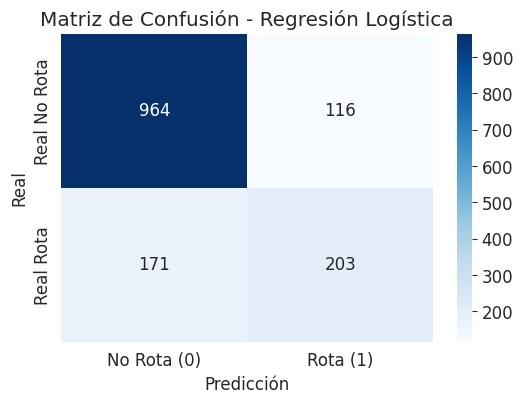


Reporte de Clasificación (Regresión Logística):
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1080
         1.0       0.64      0.54      0.59       374

    accuracy                           0.80      1454
   macro avg       0.74      0.72      0.73      1454
weighted avg       0.79      0.80      0.80      1454


--- Entrenando Modelo Random Forest ---

Métricas de evaluación para Random Forest:
Accuracy: 0.7847
Precision (Churn=1): 0.6007
Recall (Churn=1): 0.4866
F1-Score (Churn=1): 0.5377
ROC-AUC: 0.8195

Matriz de Confusión (Random Forest):
[[959 121]
 [192 182]]


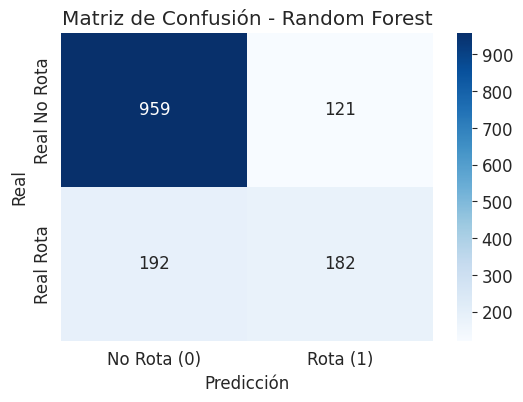


Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1080
         1.0       0.60      0.49      0.54       374

    accuracy                           0.78      1454
   macro avg       0.72      0.69      0.70      1454
weighted avg       0.77      0.78      0.78      1454


--- Resumen Comparativo de Métricas de Todos los Modelos ---
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Regresion Logistica    0.8026     0.6364  0.5428    0.5859   0.8440
Random Forest          0.7847     0.6007  0.4866    0.5377   0.8195

¡Modelos entrenados y evaluados!


In [ ]:
print("--- Paso 5: Modelado Predictivo y Evaluación ---")

# Diccionario para guardar los modelos y sus métricas
modelos = {}
metricas = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

# --- Modelo 1: Regresión Logística ---
print("\n--- Entrenando Modelo de Regresión Logística ---")
# 'liblinear' es un buen solver para datasets pequeños y medianos, y soporta penalización L1/L2
log_reg_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg_model.predict(X_test_scaled)
y_prob_log_reg = log_reg_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades de la clase positiva (Churn=1)

modelos['Regresion Logistica'] = log_reg_model

print("\nMétricas de evaluación para Regresión Logística:")
accuracy_lr = accuracy_score(y_test, y_pred_log_reg)
precision_lr = precision_score(y_test, y_pred_log_reg)
recall_lr = recall_score(y_test, y_pred_log_reg)
f1_lr = f1_score(y_test, y_pred_log_reg)
roc_auc_lr = roc_auc_score(y_test, y_prob_log_reg)

metricas.loc['Regresion Logistica'] = [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr]

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision (Churn=1): {precision_lr:.4f}")
print(f"Recall (Churn=1): {recall_lr:.4f}")
print(f"F1-Score (Churn=1): {f1_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

# Matriz de confusión para Regresión Logística
print("\nMatriz de Confusión (Regresión Logística):")
cm_lr = confusion_matrix(y_test, y_pred_log_reg)
print(cm_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rota (0)', 'Rota (1)'], yticklabels=['Real No Rota', 'Real Rota'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

print("\nReporte de Clasificación (Regresión Logística):")
print(classification_report(y_test, y_pred_log_reg))

# --- Modelo 2: Random Forest ---
print("\n--- Entrenando Modelo Random Forest ---")
# n_estimators: número de árboles en el bosque
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

modelos['Random Forest'] = rf_model

print("\nMétricas de evaluación para Random Forest:")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

metricas.loc['Random Forest'] = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision (Churn=1): {precision_rf:.4f}")
print(f"Recall (Churn=1): {recall_rf:.4f}")
print(f"F1-Score (Churn=1): {f1_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")

# Matriz de confusión para Random Forest
print("\nMatriz de Confusión (Random Forest):")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rota (0)', 'Rota (1)'], yticklabels=['Real No Rota', 'Real Rota'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

print("\nReporte de Clasificación (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("\n--- Resumen Comparativo de Métricas de Todos los Modelos ---")
print(metricas.round(4))

print("\n¡Modelos entrenados y evaluados!")

#6. Interpretación de Resultados y Conclusiones Estratégicas
Esta sección analiza la importancia de las variables para los modelos y presenta las conclusiones estratégicas, incluyendo recomendaciones accionables para la empresa

--- Paso 6: Interpretación de Resultados y Conclusiones Estratégicas ---

--- Importancia de las Características (Variables) según Random Forest ---

Top 15 Características más importantes para predecir Churn (Random Forest):
                   Caracteristica  Importancia
0                  Cargos_Totales     0.173965
1                Antiguedad_Meses     0.151854
2                 Cuentas_Diarias     0.138229
3                Cargos_Mensuales     0.130757
4   Servicio_Internet_Fiber optic     0.046246
5    Metodo_Pago_Electronic check     0.035928
6          Tipo_Contrato_Two year     0.029833
7                  Genero_Cliente     0.025737
8         Facturacion_Electronica     0.025281
9                  Cliente_Pareja     0.021630
10         Tipo_Contrato_One year     0.020741
11                Soporte_Tecnico     0.020631
12               Seguridad_Online     0.020136
13            Cliente_TerceraEdad     0.019006
14                Respaldo_Online     0.018662


/tmp/ipython-input-1263071846.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Caracteristica', data=importancia_df.head(15), palette='viridis')


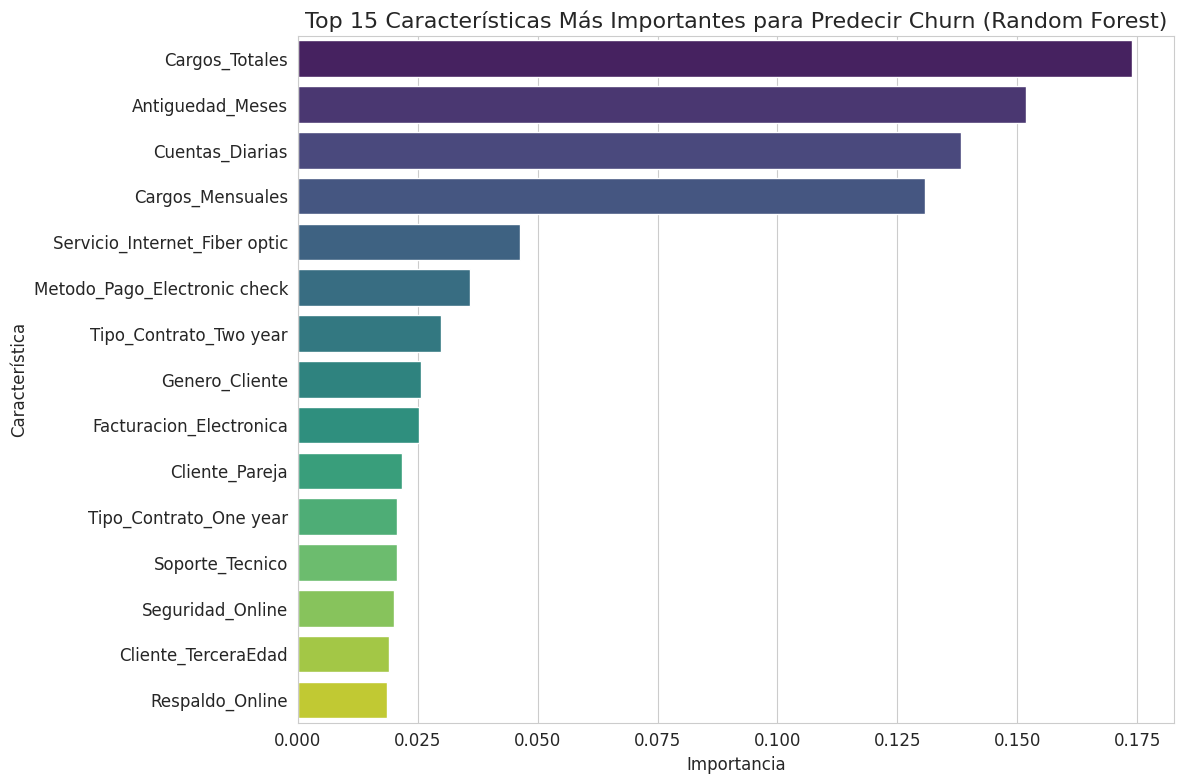


--- Coeficientes de la Regresión Logística (Influencia y Dirección) ---

Top 10 Características con mayor influencia (coeficientes) según Regresión Logística:
                  Caracteristica  Coeficiente
0               Antiguedad_Meses    -1.430913
1         Tipo_Contrato_Two year    -1.242581
2              Servicio_Telefono    -0.689419
3                 Cargos_Totales     0.683477
4         Tipo_Contrato_One year    -0.623261
5           Servicio_Internet_No    -0.578455
6  Servicio_Internet_Fiber optic     0.567019
7                Soporte_Tecnico    -0.404382
8        Facturacion_Electronica     0.384761
9               Seguridad_Online    -0.368527


/tmp/ipython-input-1263071846.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Caracteristica', data=coeficientes_df.head(15), palette='coolwarm')


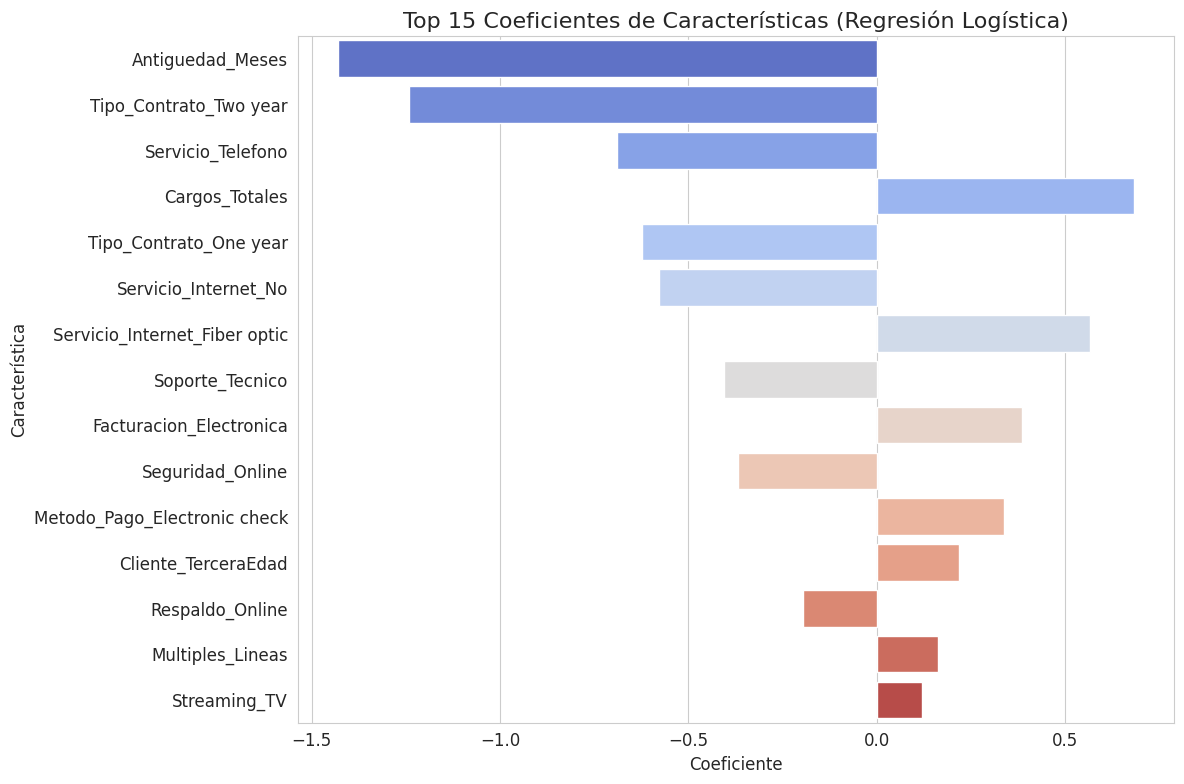

In [ ]:
print("--- Paso 6: Interpretación de Resultados y Conclusiones Estratégicas ---")

# 1. Análisis de Importancia de Variables (Random Forest)
print("\n--- Importancia de las Características (Variables) según Random Forest ---")

# Asegurarse de que X_train_scaled es un DataFrame con nombres de columnas
if not isinstance(X_train_scaled, pd.DataFrame):
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)

feature_importances = rf_model.feature_importances_
importancia_df = pd.DataFrame({
    'Caracteristica': X_train_scaled.columns,
    'Importancia': feature_importances
})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

print("\nTop 15 Características más importantes para predecir Churn (Random Forest):")
print(importancia_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Caracteristica', data=importancia_df.head(15), palette='viridis')
plt.title('Top 15 Características Más Importantes para Predecir Churn (Random Forest)', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Coeficientes de Regresión Logística (para entender la dirección de la influencia)
print("\n--- Coeficientes de la Regresión Logística (Influencia y Dirección) ---")
coeficientes_df = pd.DataFrame({
    'Caracteristica': X_train_scaled.columns,
    'Coeficiente': log_reg_model.coef_[0]
})
coeficientes_df['Abs_Coeficiente'] = coeficientes_df['Coeficiente'].abs()
coeficientes_df = coeficientes_df.sort_values(by='Abs_Coeficiente', ascending=False).reset_index(drop=True)

print("\nTop 10 Características con mayor influencia (coeficientes) según Regresión Logística:")
print(coeficientes_df.drop('Abs_Coeficiente', axis=1).head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Coeficiente', y='Caracteristica', data=coeficientes_df.head(15), palette='coolwarm')
plt.title('Top 15 Coeficientes de Características (Regresión Logística)', fontsize=16)
plt.xlabel('Coeficiente', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

#**Código para Generar y Guardar Gráfico**s


Carpeta 'visualizations' ya existe.


/tmp/ipython-input-3622224940.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='coolwarm')


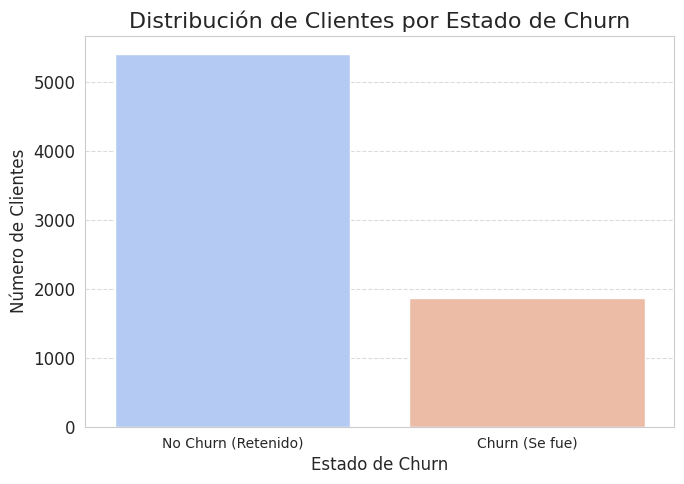


Gráfico 'churn_distribution.png' guardado y mostrado.


/tmp/ipython-input-3622224940.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Caracteristica', data=importancia_df.head(15), palette='viridis')


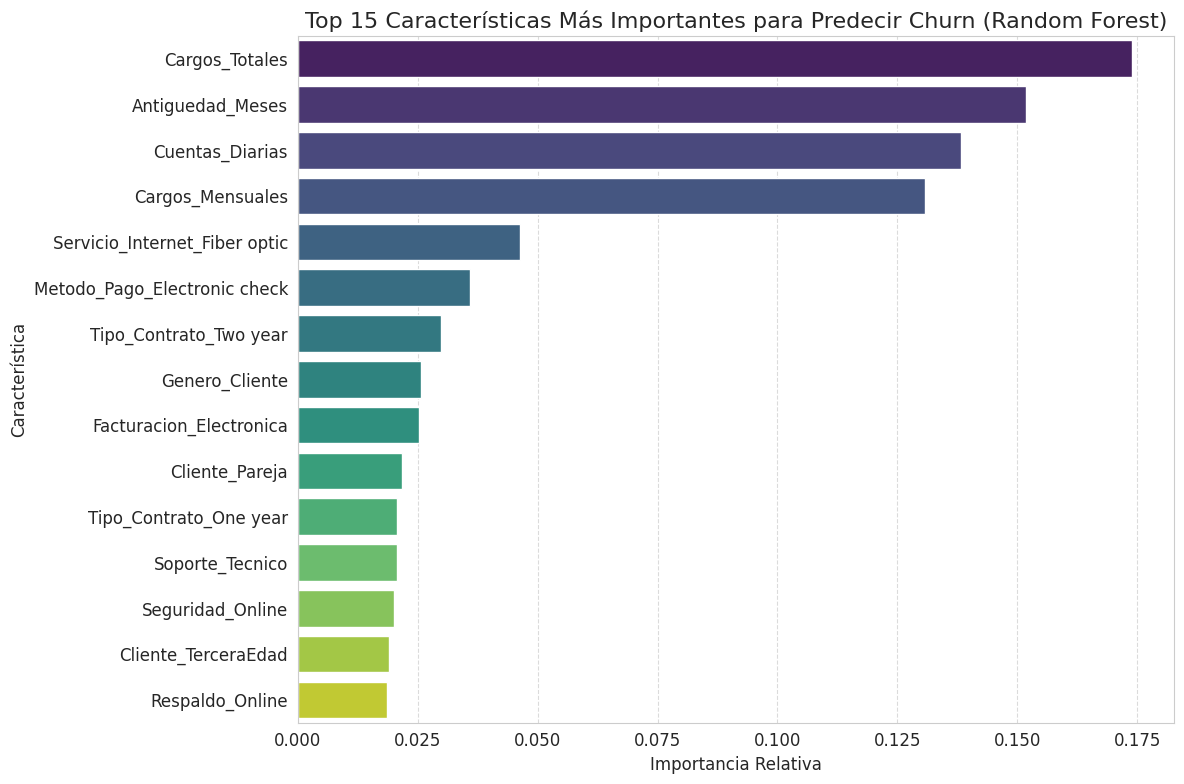


Gráfico 'feature_importance.png' guardado y mostrado.


/tmp/ipython-input-3622224940.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Caracteristica', data=coeficientes_df.head(15), palette='coolwarm')


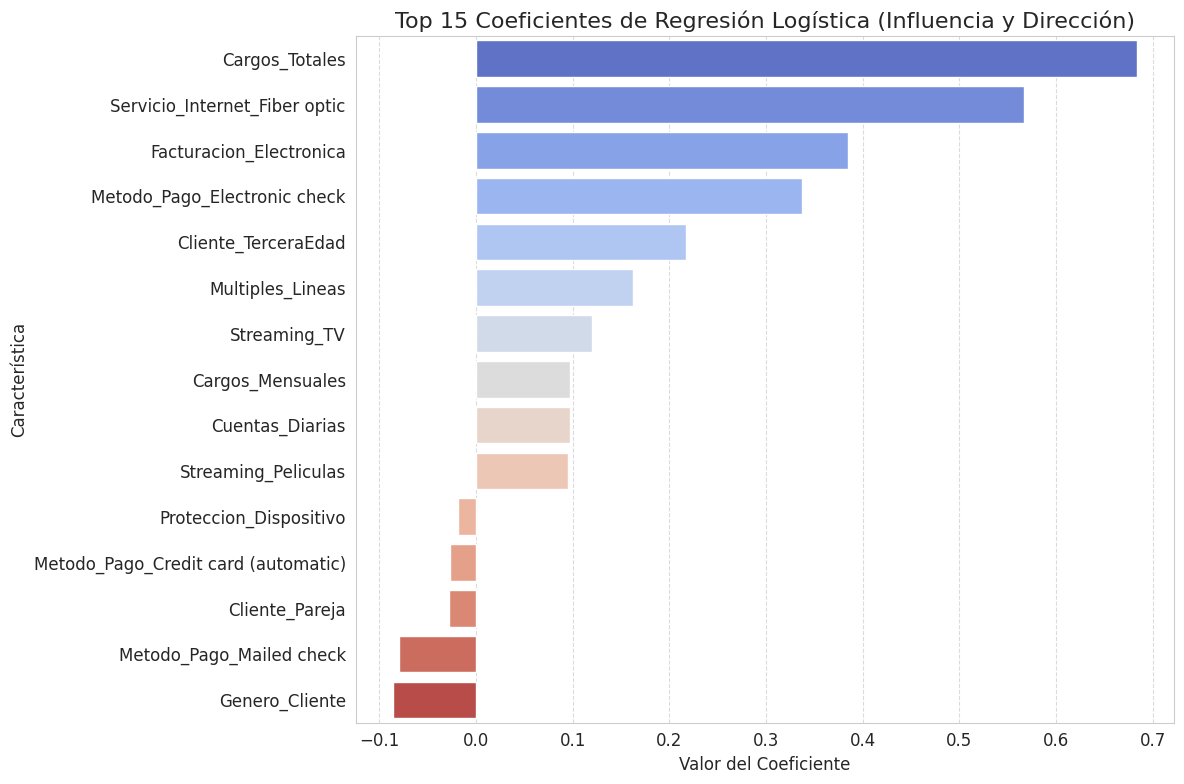


Gráfico 'logistic_coefficients.png' guardado y mostrado.

--- ¡Generación y guardado de gráficos completado! ---


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os # Para manejar directorios

# --- 1. Crear la carpeta para visualizaciones si no existe ---
# Esto es crucial para que los archivos se guarden en el lugar correcto
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')
    print("Carpeta 'visualizations' creada.")
else:
    print("Carpeta 'visualizations' ya existe.")

# --- 2. Gráfico de Distribución de la Variable Objetivo 'Churn' ---
# Asumiendo que 'df_clientes' ya tiene la columna 'Churn' como 0 y 1 después de la limpieza.

# Asegúrate de que Churn sea int para el conteo si no lo hiciste antes (idealmente ya lo hiciste)
# df_clientes['Churn'] = pd.to_numeric(df_clientes['Churn'], errors='coerce').fillna(0).astype(int) # Descomentar si el Churn aún tiene '' o NaN

churn_counts = df_clientes['Churn'].value_counts()

plt.figure(figsize=(7, 5))
# Usamos un mapa de colores 'coolwarm' para distinguir las dos categorías
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='coolwarm')
plt.title('Distribución de Clientes por Estado de Churn', fontsize=16)
plt.xlabel('Estado de Churn', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
# Cambiamos las etiquetas del eje X para que sean más descriptivas
plt.xticks(ticks=[0, 1], labels=['No Churn (Retenido)', 'Churn (Se fue)'], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para que quepan en el área de la figura.
plt.savefig('visualizations/churn_distribution.png')
plt.show()

print("\nGráfico 'churn_distribution.png' guardado y mostrado.")

# --- 3. Gráfico de Importancia de las Características (Random Forest) ---
# Necesitas haber entrenado tu modelo 'rf_model' (RandomForestClassifier)
# y haber preparado tus características X (sin customerID, ya codificadas y escaladas)

try:
    # Asegúrate de que X es tu DataFrame de características pre-escalado/codificado
    # X_train después de OHE y escalado es lo que se usó para entrenar rf_model
    # Las columnas de X_train deben ser las mismas que las usadas para .feature_importances_

    # Crea un DataFrame para la importancia de las características
    importancia_df = pd.DataFrame({
        'Caracteristica': X_train.columns, # Usa las columnas de tus datos de entrenamiento
        'Importancia': rf_model.feature_importances_
    }).sort_values(by='Importancia', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importancia', y='Caracteristica', data=importancia_df.head(15), palette='viridis')
    plt.title('Top 15 Características Más Importantes para Predecir Churn (Random Forest)', fontsize=16)
    plt.xlabel('Importancia Relativa', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('visualizations/feature_importance.png')
    plt.show()

    print("\nGráfico 'feature_importance.png' guardado y mostrado.")

except NameError:
    print("\nAdvertencia: El modelo 'rf_model' o el DataFrame 'X_train' no se encontraron. Salto el gráfico de importancia de características.")
except AttributeError:
    print("\nAdvertencia: El modelo 'rf_model' no tiene el atributo 'feature_importances_'. Salto el gráfico de importancia de características.")


# --- 4. Gráfico de Coeficientes de Regresión Logística ---
# Necesitas haber entrenado tu modelo 'log_reg_model' (LogisticRegression)
# y haber preparado tus características X (sin customerID, ya codificadas y escaladas)

try:
    # Crea un DataFrame para los coeficientes
    coeficientes_df = pd.DataFrame({
        'Caracteristica': X_train.columns, # Usa las columnas de tus datos de entrenamiento
        'Coeficiente': log_reg_model.coef_[0] # log_reg_model.coef_ es un array de arrays
    }).sort_values(by='Coeficiente', ascending=False) # Ordenar para visualizar mejor

    plt.figure(figsize=(12, 8))
    # Usamos 'coolwarm' para mostrar la dirección (positivo/negativo)
    sns.barplot(x='Coeficiente', y='Caracteristica', data=coeficientes_df.head(15), palette='coolwarm')
    plt.title('Top 15 Coeficientes de Regresión Logística (Influencia y Dirección)', fontsize=16)
    plt.xlabel('Valor del Coeficiente', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('visualizations/logistic_coefficients.png')
    plt.show()

    print("\nGráfico 'logistic_coefficients.png' guardado y mostrado.")

except NameError:
    print("\nAdvertencia: El modelo 'log_reg_model' o el DataFrame 'X_train' no se encontraron. Salto el gráfico de coeficientes.")
except AttributeError:
    print("\nAdvertencia: El modelo 'log_reg_model' no tiene el atributo 'coef_'. Salto el gráfico de coeficientes.")

print("\n--- ¡Generación y guardado de gráficos completado! ---")

# **Guardar** el DataFrame Final como Archivo CSV

In [ ]:
import pandas as pd
import os

if not os.path.exists('data/processed'):
    os.makedirs('data/processed')
    print("Carpeta 'data/processed' creada.")
else:
    print("Carpeta 'data/processed' ya existe.")

# --- 2. Definir la ruta completa para el archivo CSV ---
output_csv_path = 'data/processed/df_clientes_processed.csv'

# --- 3. Guardar el DataFrame como CSV ---
df_clientes.to_csv(output_csv_path, index=False)

print(f"\nDataFrame guardado exitosamente en: {output_csv_path}")



Carpeta 'data/processed' creada.

DataFrame guardado exitosamente en: data/processed/df_clientes_processed.csv
